-------------------------------------
# **Somerville Community Path and Weather Analysis**
-------------------------------------

--------------------
## **Context**
--------------------



------------------
## **Objective**
------------------

To extract actionable insights around demand patterns across various factors.

-----------------------------
## **Key Questions**
-----------------------------



------------------------------------
## **Dataset Description**
------------------------------------

The data contains information about the usage of Community Path from Jan 12, 2023 at midnight to May 14, 2024 at 4:15pm, every 15 minutes.



Weather data contains information from May 17, 2023 at 12:20am to May 15, 2024 at 10:20pm, every 5 minutes.

The intersection of these time periods is May 17, 2023 (12:30am) to May 14, 2024 (4:15pm), or nearly a year of data at 15-minute samples, so roughly 35,000 data points. The Somerville Community Path extension opened June 10, 2023. Somerville Porchfest was May 11, 2024.  

* dt: Date and time of observation
* Ped_IN: Pedestrians detected entering during the time window
* Ped_OUT: Pedestrians detected entering during the time window

##  **Importing the necessary libraries and overview of the dataset**

In [167]:
# Library to suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [168]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libraries to help with data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Library to extract datetime features
import datetime as dt
# Importing libraries for scaling the data
from sklearn.preprocessing import MinMaxScaler
# Importing libraries for building linear regression model
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing libraries for scaling the data
from sklearn.preprocessing import MinMaxScaler

In [169]:
#from google.colab import drive
#drive.mount('/content/drive')

### **Loading the dataset**

In [170]:
#data = pd.read_csv('/content/drive/MyDrive/MIT_course/MLS_1_uber/Uber.csv')
use_data = pd.read_excel('https://github.com/jesusina/comm_path_weather_usage/blob/main/somerville_comm_path_ped_count_2023-2024.xlsx?raw=true')
weather_data=pd.read_csv('https://github.com/jesusina/comm_path_weather_usage/blob/main/ambient-weather-20230517-20240515.csv?raw=true')

In [171]:
## Copying data to another variable to avoid any changes to the original data
#df = data.copy()
df_use=use_data.copy()
df_weather=weather_data.copy()

### **Exploring Usage DataFrame**

In [172]:
# Looking at head (the first 5 observations)
df_use.head(5)

Site Name   Somerville - Community Path @ Cedar  YPI16039507  \
0      Site Identifier                                          100030588   
1      Flow Identifier                                          101030588   
2            Flow Name  Somerville - Community Path @ Cedar  YPI160395...   
3  2023-01-12 00:00:00                                                  0   
4  2023-01-12 00:15:00                                                  0   

  Somerville - Community Path @ Cedar  YPI16039507.1  
0                                          100030588  
1                                          102030588  
2  Somerville - Community Path @ Cedar  YPI160395...  
3                                                  0  
4                                                  0

In [173]:
df_use.columns

Index(['Site Name', 'Somerville - Community Path @ Cedar  YPI16039507',
       'Somerville - Community Path @ Cedar  YPI16039507.1'],
      dtype='object')

In [174]:
#friendlier column names
df_use.columns=["Dt", 'Ped_IN', 'Ped_OUT']

In [175]:
df_use.tail(5)

Dt Ped_IN Ped_OUT
47008  2024-05-15 15:15:00    NaN     NaN
47009  2024-05-15 15:30:00    NaN     NaN
47010  2024-05-15 15:45:00    NaN     NaN
47011  2024-05-15 16:00:00    NaN     NaN
47012  2024-05-15 16:15:00    NaN     NaN

We can already see there are missing values to deal with.  Removing top two rows, which contain location information.

In [176]:
df_use=df_use.iloc[3:]


In [177]:
df_use.head(5)

Dt Ped_IN Ped_OUT
3  2023-01-12 00:00:00      0       0
4  2023-01-12 00:15:00      0       0
5  2023-01-12 00:30:00      0       0
6  2023-01-12 00:45:00      0       0
7  2023-01-12 01:00:00      0       0

In [178]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47010 entries, 3 to 47012
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Dt       47010 non-null  object
 1   Ped_IN   46914 non-null  object
 2   Ped_OUT  46914 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


We have 47010-46914 = 96 missing values for Ped_IN and Ped_OUT. These are easily enough filled in with zeros.

In [179]:
indices_to_be_updated=df_use[df_use['Ped_IN'].isnull()].index
df_use.loc[indices_to_be_updated, 'Ped_IN']="0"
indices_to_be_updated=df_use[df_use['Ped_OUT'].isnull()].index
df_use.loc[indices_to_be_updated, 'Ped_OUT']="0"

In [180]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47010 entries, 3 to 47012
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Dt       47010 non-null  object
 1   Ped_IN   47010 non-null  object
 2   Ped_OUT  47010 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [181]:
df_use[['Ped_IN','Ped_OUT']]=df_use[['Ped_IN','Ped_OUT']].astype(int)

In [182]:
print(df_use['Ped_IN'].corr(df_use['Ped_OUT']))

0.7960051285577484


The number of pedestrians entering and exiting is highly correlated, though notably not perfectly.

In [183]:
print("Ped_IN total: ", df_use['Ped_IN'].sum())
print("Ped_OUT total: ", df_use['Ped_OUT'].sum())

Ped_IN total:  757317
Ped_OUT total:  651765


In [184]:
df_use.describe().T

count       mean        std  min  25%   50%   75%    max
Ped_IN   47010.0  16.109700  17.121541  0.0  2.0  12.0  25.0  365.0
Ped_OUT  47010.0  13.864391  15.644887  0.0  1.0   9.0  22.0  696.0

There must be other exit points beyond the point recorded here; else, there is sensor unreliability to be considered.

### **Exploring Weather DataFrame**

In [185]:
df_weather.head(5)

Date          Simple Date  Outdoor Temperature (°F)  \
0  2024-05-15T22:20:00-04:00  2024-05-15 22:20:00                      59.9   
1  2024-05-15T22:15:00-04:00  2024-05-15 22:15:00                      60.1   
2  2024-05-15T22:10:00-04:00  2024-05-15 22:10:00                      60.3   
3  2024-05-15T22:05:00-04:00  2024-05-15 22:05:00                      60.3   
4  2024-05-15T22:00:00-04:00  2024-05-15 22:00:00                      60.4   

   Feels Like (°F)  Dew Point (°F)  Wind Speed (mph)  Wind Gust (mph)  \
0             59.9            59.3               0.0              0.0   
1             60.1            59.5               0.0              0.0   
2             60.3            59.4               0.0              0.0   
3             60.3            59.4               0.0              0.0   
4             60.4            59.3               0.0              0.0   

   Max Daily Gust (mph)  Wind Direction (°)  Hourly Rain (in/hr)  ...  \
0                  13.6                  63                 0.07  ...   
1                  13.6                  23                 0.07  ...   
2                  13.6                  51                 0.05  ...   
3                  13.6                  57                 0.05  ...   
4                  13.6                  91                 0.00  ...   

   Ultra-Violet Radiation Index  Solar Radiation (W/m^2)  \
0                             0                      0.0   
1                             0                      0.0   
2                             0                      0.0   
3                             0                      0.0   
4                             0                      0.0   

   Lightning strikes per day  Lightning strikes per hour  \
0                          0                           0   
1                          0                           0   
2                          0                           0   
3                          0                           0   
4                          0                           0   

   Indoor Temperature (°F)  Indoor Humidity (%)  Absolute Pressure (inHg)  \
0                     70.3                   61                     29.79   
1                     70.2                   61                     29.79   
2                     70.2                   61                     29.79   
3                     70.2                   61                     29.79   
4                     70.3                   60                     29.79   

   Outdoor Battery  Indoor Feels Like (°F)  Indoor Dew Point (°F)  
0                1                    69.9                   56.2  
1                1                    69.8                   56.1  
2                1                    69.8                   56.1  
3                1                    69.8                   56.1  
4                1                    69.8                   55.7  

[5 rows x 27 columns]

In [186]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104814 entries, 0 to 104813
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Date                          104814 non-null  object 
 1   Simple Date                   104814 non-null  object 
 2   Outdoor Temperature (°F)      104814 non-null  float64
 3   Feels Like (°F)               104814 non-null  float64
 4   Dew Point (°F)                104814 non-null  float64
 5   Wind Speed (mph)              104814 non-null  float64
 6   Wind Gust (mph)               104814 non-null  float64
 7   Max Daily Gust (mph)          104814 non-null  float64
 8   Wind Direction (°)            104814 non-null  int64  
 9   Hourly Rain (in/hr)           104814 non-null  float64
 10  Event Rain (in)               104814 non-null  float64
 11  Daily Rain (in)               104814 non-null  float64
 12  Weekly Rain (in)              104814 non-nul

In [187]:
# date format is redundant
df_weather.drop(columns="Date", axis=1, inplace=True)

In [188]:
df_weather.describe().T

count        mean         std     min  \
Outdoor Temperature (°F)      104814.0   53.288335   16.591344   13.50   
Feels Like (°F)               104814.0   53.336415   17.695463    0.90   
Dew Point (°F)                104814.0   45.505376   17.353398    1.00   
Wind Speed (mph)              104814.0    1.241173    2.164465    0.00   
Wind Gust (mph)               104814.0    2.182035    3.429592    0.00   
Max Daily Gust (mph)          104814.0   12.243922    7.389834    0.00   
Wind Direction (°)            104814.0  184.759431  120.465671    0.00   
Hourly Rain (in/hr)           104814.0    0.008912    0.064905    0.00   
Event Rain (in)               104814.0    0.284043    0.640261    0.00   
Daily Rain (in)               104814.0    0.101159    0.338483    0.00   
Weekly Rain (in)              104814.0    0.707159    0.995107    0.00   
Monthly Rain (in)             104814.0    3.152932    2.818928    0.00   
Total Rain (in)               104814.0  220.934093   16.026675  186.28   
Relative Pressure (inHg)      104814.0   29.774092    0.260703   28.71   
Humidity (%)                  104814.0   77.120633   18.443038   23.00   
Ultra-Violet Radiation Index  104814.0    0.935753    1.810679    0.00   
Solar Radiation (W/m^2)       104814.0  118.390434  200.928447    0.00   
Lightning strikes per day     104814.0    0.000000    0.000000    0.00   
Lightning strikes per hour    104814.0    0.000000    0.000000    0.00   
Indoor Temperature (°F)       104814.0   68.520592    7.395994   55.00   
Indoor Humidity (%)           104814.0   49.790934    9.855429   22.00   
Absolute Pressure (inHg)      104814.0   29.924689    0.260744   28.86   
Outdoor Battery               104814.0    1.000000    0.000000    1.00   
Indoor Feels Like (°F)        104814.0   68.739258    8.136099   55.00   
Indoor Dew Point (°F)         104814.0   48.663068   10.954668   24.50   

                                 25%     50%     75%      max  
Outdoor Temperature (°F)       39.90   52.00   67.10    96.80  
Feels Like (°F)                39.30   52.00   67.10   112.10  
Dew Point (°F)                 32.50   45.90   59.50    80.60  
Wind Speed (mph)                0.00    0.00    1.80    25.50  
Wind Gust (mph)                 0.00    0.00    3.40    37.60  
Max Daily Gust (mph)            6.90   11.40   15.90    43.40  
Wind Direction (°)             59.00  199.00  295.00   359.00  
Hourly Rain (in/hr)             0.00    0.00    0.00     3.54  
Event Rain (in)                 0.00    0.00    0.17     3.38  
Daily Rain (in)                 0.00    0.00    0.00     2.93  
Weekly Rain (in)                0.00    0.23    1.05     5.79  
Monthly Rain (in)               0.42    2.55    5.45    11.13  
Total Rain (in)               209.03  223.33  236.22   236.22  
Relative Pressure (inHg)       29.61   29.77   29.95    30.44  
Humidity (%)                   63.00   80.00   94.00    99.00  
Ultra-Violet Radiation Index    0.00    0.00    1.00    11.00  
Solar Radiation (W/m^2)         0.00    1.45  156.90  1152.20  
Lightning strikes per day       0.00    0.00    0.00     0.00  
Lightning strikes per hour      0.00    0.00    0.00     0.00  
Indoor Temperature (°F)        62.80   66.60   73.80    90.10  
Indoor Humidity (%)            42.00   48.00   57.00    84.00  
Absolute Pressure (inHg)       29.76   29.92   30.10    30.59  
Outdoor Battery                 1.00    1.00    1.00     1.00  
Indoor Feels Like (°F)         62.80   66.60   73.60    99.40  
Indoor Dew Point (°F)          40.60   45.70   56.70    74.00

In [189]:
#renaming to simpler column to prepare to merge the dataframes
df_weather['Dt']=df_weather['Simple Date']
df_weather.drop('Simple Date', axis=1, inplace=True)

In [190]:
df_weather.columns

Index(['Outdoor Temperature (°F)', 'Feels Like (°F)', 'Dew Point (°F)',
       'Wind Speed (mph)', 'Wind Gust (mph)', 'Max Daily Gust (mph)',
       'Wind Direction (°)', 'Hourly Rain (in/hr)', 'Event Rain (in)',
       'Daily Rain (in)', 'Weekly Rain (in)', 'Monthly Rain (in)',
       'Total Rain (in)', 'Relative Pressure (inHg)', 'Humidity (%)',
       'Ultra-Violet Radiation Index', 'Solar Radiation (W/m^2)',
       'Lightning strikes per day', 'Lightning strikes per hour',
       'Indoor Temperature (°F)', 'Indoor Humidity (%)',
       'Absolute Pressure (inHg)', 'Outdoor Battery', 'Indoor Feels Like (°F)',
       'Indoor Dew Point (°F)', 'Dt'],
      dtype='object')

In [191]:
df_weather.head(3)

Outdoor Temperature (°F)  Feels Like (°F)  Dew Point (°F)  \
0                      59.9             59.9            59.3   
1                      60.1             60.1            59.5   
2                      60.3             60.3            59.4   

   Wind Speed (mph)  Wind Gust (mph)  Max Daily Gust (mph)  \
0               0.0              0.0                  13.6   
1               0.0              0.0                  13.6   
2               0.0              0.0                  13.6   

   Wind Direction (°)  Hourly Rain (in/hr)  Event Rain (in)  Daily Rain (in)  \
0                  63                 0.07             0.10             0.10   
1                  23                 0.07             0.10             0.10   
2                  51                 0.05             0.09             0.09   

   ...  Solar Radiation (W/m^2)  Lightning strikes per day  \
0  ...                      0.0                          0   
1  ...                      0.0                          0   
2  ...                      0.0                          0   

   Lightning strikes per hour  Indoor Temperature (°F)  Indoor Humidity (%)  \
0                           0                     70.3                   61   
1                           0                     70.2                   61   
2                           0                     70.2                   61   

   Absolute Pressure (inHg)  Outdoor Battery  Indoor Feels Like (°F)  \
0                     29.79                1                    69.9   
1                     29.79                1                    69.8   
2                     29.79                1                    69.8   

   Indoor Dew Point (°F)                   Dt  
0                   56.2  2024-05-15 22:20:00  
1                   56.1  2024-05-15 22:15:00  
2                   56.1  2024-05-15 22:10:00  

[3 rows x 26 columns]

In [192]:
df_use.tail(3)

Dt  Ped_IN  Ped_OUT
47010  2024-05-15 15:45:00       0        0
47011  2024-05-15 16:00:00       0        0
47012  2024-05-15 16:15:00       0        0

### **Joining the Two DataFrames**

In [193]:
df_use.Dt = pd.to_datetime(df_use.Dt)
df_weather.Dt = pd.to_datetime(df_weather.Dt)

In [194]:
#for all common date times, join the tables.  Discard rows without counterparts (e.g. first 5 months of Use data, which lacks weather data)
df_master=pd.merge(df_use, df_weather, how='inner', on='Dt')

In [195]:
df_master.head(5)

Dt  Ped_IN  Ped_OUT  Outdoor Temperature (°F)  \
0 2023-05-17 00:00:00       2        2                      66.9   
1 2023-05-17 00:15:00       1        3                      66.7   
2 2023-05-17 00:30:00       0        0                      64.8   
3 2023-05-17 00:45:00       0        0                      63.0   
4 2023-05-17 01:00:00       0        0                      62.2   

   Feels Like (°F)  Dew Point (°F)  Wind Speed (mph)  Wind Gust (mph)  \
0             66.9            48.2               0.0              0.0   
1             66.7            45.8               0.7              1.1   
2             64.8            45.7               0.9              2.2   
3             63.0            46.6               3.4              5.8   
4             62.2            46.8               0.0              0.0   

   Max Daily Gust (mph)  Wind Direction (°)  ...  \
0                   0.0                 330  ...   
1                   8.1                  25  ...   
2                   9.2                  23  ...   
3                  10.3                  47  ...   
4                  10.3                  20  ...   

   Ultra-Violet Radiation Index  Solar Radiation (W/m^2)  \
0                             0                      0.0   
1                             0                      0.0   
2                             0                      0.0   
3                             0                      0.0   
4                             0                      0.0   

   Lightning strikes per day  Lightning strikes per hour  \
0                          0                           0   
1                          0                           0   
2                          0                           0   
3                          0                           0   
4                          0                           0   

   Indoor Temperature (°F)  Indoor Humidity (%)  Absolute Pressure (inHg)  \
0                     73.2                   34                     29.43   
1                     73.2                   35                     29.42   
2                     72.9                   35                     29.42   
3                     72.7                   35                     29.42   
4                     72.7                   35                     29.44   

   Outdoor Battery  Indoor Feels Like (°F)  Indoor Dew Point (°F)  
0                1                    71.8                   43.1  
1                1                    71.9                   43.9  
2                1                    71.5                   43.6  
3                1                    71.3                   43.5  
4                1                    71.3                   43.5  

[5 rows x 28 columns]

In [196]:
# Extracting date parts from pickup_dt
df_master['year'] = df_master.Dt.dt.year

df_master['month'] = df_master.Dt.dt.month_name()

df_master['hour'] = df_master.Dt.dt.hour

df_master['day'] = df_master.Dt.dt.day

df_master['week_day'] = df_master.Dt.dt.day_name()
#df_master.drop('Dt', axis=1, inplace=True)

In [197]:
df_master.describe().T

count                           mean  \
Dt                              34333  2023-11-15 14:17:43.731686656   
Ped_IN                        34333.0                      17.033903   
Ped_OUT                       34333.0                      14.439956   
Outdoor Temperature (°F)      34333.0                      53.336571   
Feels Like (°F)               34333.0                      53.390216   
Dew Point (°F)                34333.0                      45.556237   
Wind Speed (mph)              34333.0                       1.240655   
Wind Gust (mph)               34333.0                       2.180532   
Max Daily Gust (mph)          34333.0                      12.190187   
Wind Direction (°)            34333.0                     184.442635   
Hourly Rain (in/hr)           34333.0                       0.008957   
Event Rain (in)               34333.0                       0.284348   
Daily Rain (in)               34333.0                       0.100741   
Weekly Rain (in)              34333.0                       0.703631   
Monthly Rain (in)             34333.0                       3.154204   
Total Rain (in)               34333.0                     220.900534   
Relative Pressure (inHg)      34333.0                       29.77396   
Humidity (%)                  34333.0                      77.137914   
Ultra-Violet Radiation Index  34333.0                       0.937757   
Solar Radiation (W/m^2)       34333.0                     118.562974   
Lightning strikes per day     34333.0                            0.0   
Lightning strikes per hour    34333.0                            0.0   
Indoor Temperature (°F)       34333.0                      68.538103   
Indoor Humidity (%)           34333.0                      49.798212   
Absolute Pressure (inHg)      34333.0                      29.924565   
Outdoor Battery               34333.0                            1.0   
Indoor Feels Like (°F)        34333.0                      68.758675   
Indoor Dew Point (°F)         34333.0                      48.681592   
year                          34333.0                    2023.373664   
hour                          34333.0                      11.487112   
day                           34333.0                      15.756328   

                                              min                  25%  \
Dt                            2023-05-17 00:00:00  2023-08-16 11:45:00   
Ped_IN                                        0.0                  2.0   
Ped_OUT                                       0.0                  1.0   
Outdoor Temperature (°F)                     13.5                 40.1   
Feels Like (°F)                               1.9                 39.4   
Dew Point (°F)                                1.0                 32.6   
Wind Speed (mph)                              0.0                  0.0   
Wind Gust (mph)                               0.0                  0.0   
Max Daily Gust (mph)                          0.0                  6.9   
Wind Direction (°)                            0.0                 59.0   
Hourly Rain (in/hr)                           0.0                  0.0   
Event Rain (in)                               0.0                  0.0   
Daily Rain (in)                               0.0                  0.0   
Weekly Rain (in)                              0.0                  0.0   
Monthly Rain (in)                             0.0                 0.42   
Total Rain (in)                            186.28               209.03   
Relative Pressure (inHg)                    28.71                29.61   
Humidity (%)                                 23.0                 63.0   
Ultra-Violet Radiation Index                  0.0                  0.0   
Solar Radiation (W/m^2)                       0.0                  0.0   
Lightning strikes per day                     0.0                  0.0   
Lightning strikes per hour                    0.0                  0.0   
Indoor Temperature (°F)  

In [198]:
#dropping categories containing no information
df_master.drop(['Outdoor Battery','Lightning strikes per day','Lightning strikes per hour'], axis=1, inplace=True)

In [199]:
num_cols=df_master.select_dtypes(include=['number']).columns.tolist()
print(num_cols)

['Ped_IN', 'Ped_OUT', 'Outdoor Temperature (°F)', 'Feels Like (°F)', 'Dew Point (°F)', 'Wind Speed (mph)', 'Wind Gust (mph)', 'Max Daily Gust (mph)', 'Wind Direction (°)', 'Hourly Rain (in/hr)', 'Event Rain (in)', 'Daily Rain (in)', 'Weekly Rain (in)', 'Monthly Rain (in)', 'Total Rain (in)', 'Relative Pressure (inHg)', 'Humidity (%)', 'Ultra-Violet Radiation Index', 'Solar Radiation (W/m^2)', 'Indoor Temperature (°F)', 'Indoor Humidity (%)', 'Absolute Pressure (inHg)', 'Indoor Feels Like (°F)', 'Indoor Dew Point (°F)', 'year', 'hour', 'day']


In [200]:
corr=df_master[num_cols].corr()

### **First Correlation Heat Map**

<Axes: >

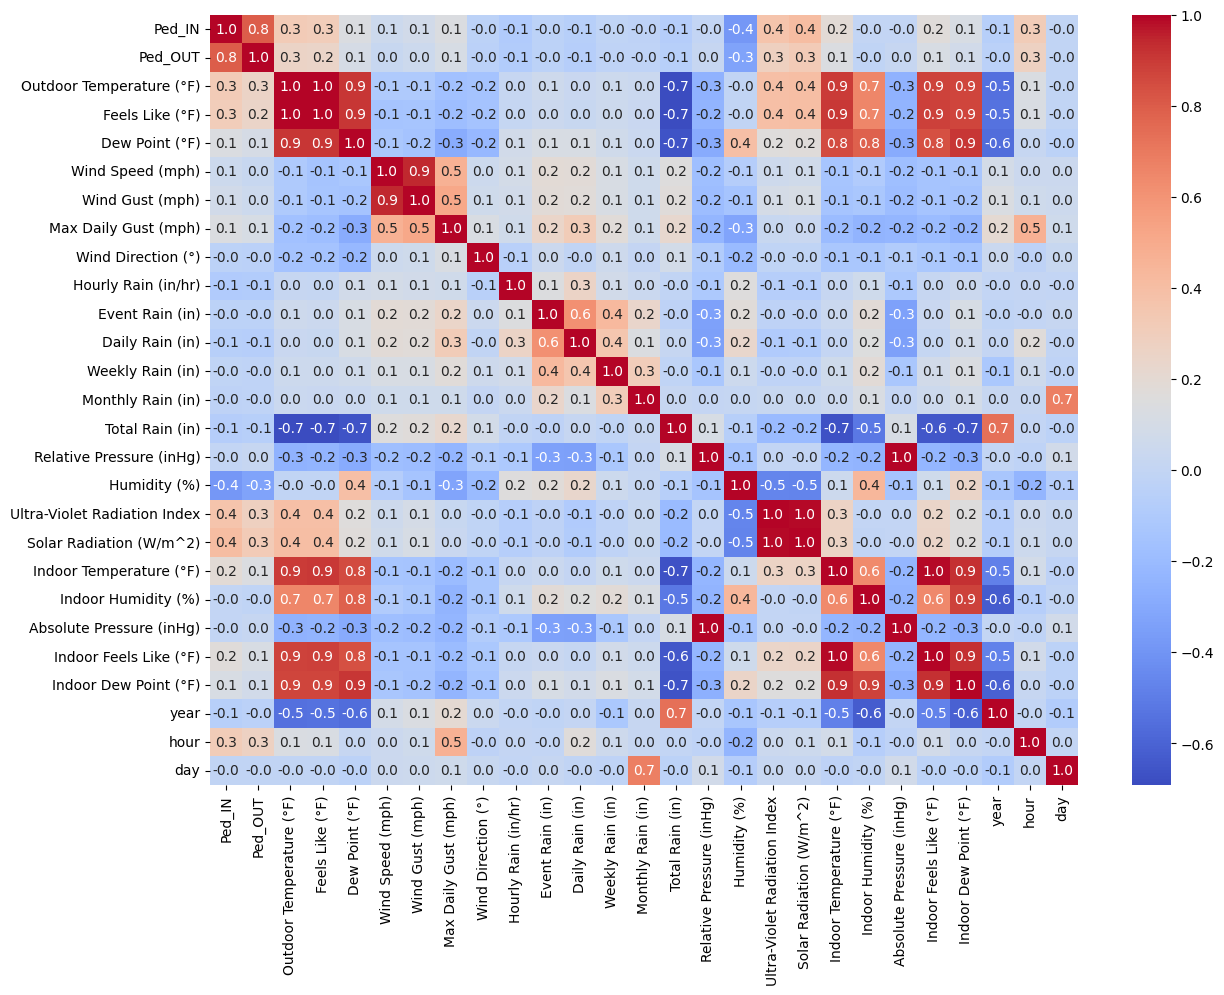

In [201]:
# Plot the heatmap
plt.figure(figsize = (14, 10))
sns.heatmap(corr, annot = True, cmap = 'coolwarm',
        fmt = ".1f",
        xticklabels = corr.columns,
        yticklabels = corr.columns)

### **First impressions from correlation analysis**
* **Ultra-Violet Radiation Index** and **Solar Radiation** are most strongly correlated with pedestrian count (which have perfect correlation with each other), followed by **Outdoor temperature** and **feels like** (likewise perfectly correlated).  In summary: nothing brings people out like sun and warmth. However, this might just be an artifact of temperature and sun being higher during the waking hours when people are out.  See: *Hour of the Day* analysis below.
* Rain and wind have surprisingly little correlation to pedestrian count.  The relationship to pedestrian count may be accounted for more effective under sunshine-related variables, as it does not generally rain or wind on sunny days.
* High **humidity (%)** is the strongest deterrent of pedestrian us. However, this might just be an artifact of humidity being higher during overnight hours when people are inside.
* Surprisingly, the indoor weather variables do have strong relationships with outdoor ones. Indoor temperature, humidity, dewpoint, and feelslike are all strongly correlated with all of their outdoor counterparts.  
* All the rain variables are correlated, as are all of the wind variables

### **Bivariate scatterplots**

<Axes: xlabel='Solar Radiation (W/m^2)', ylabel='Ultra-Violet Radiation Index'>

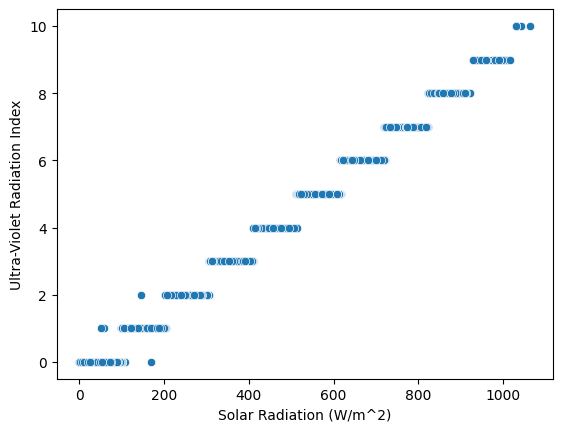

In [202]:
sns.scatterplot(data=df_master, x='Solar Radiation (W/m^2)', y='Ultra-Violet Radiation Index')

UV Rad. Index is almost exactly a step function of overall solar radiation.

<Axes: xlabel='Outdoor Temperature (°F)', ylabel='Feels Like (°F)'>

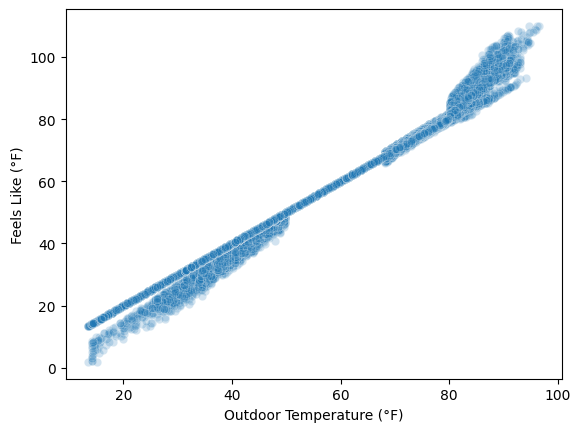

In [203]:
sns.scatterplot(data=df_master, x='Outdoor Temperature (°F)', y='Feels Like (°F)', alpha=.2)

**Feels like** is simply the weather station applying formulas so this makes sense.  We can see that wind chill isn't counted above 50F and heat index doesn't contribute until around 70F.

<Axes: xlabel='Event Rain (in)', ylabel='Daily Rain (in)'>

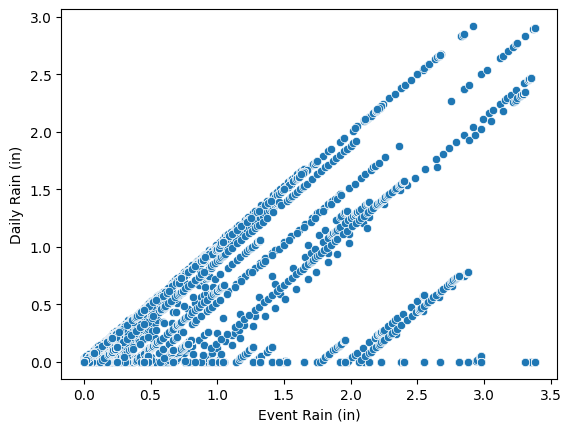

In [204]:
sns.scatterplot(data=df_master, x='Event Rain (in)', y='Daily Rain (in)')

Daily Rain can never be more than the Event Rain, suggesting that "Event Rain" is a cumulative count that could be over several days.

<Axes: xlabel='Hourly Rain (in/hr)', ylabel='Ped_IN'>

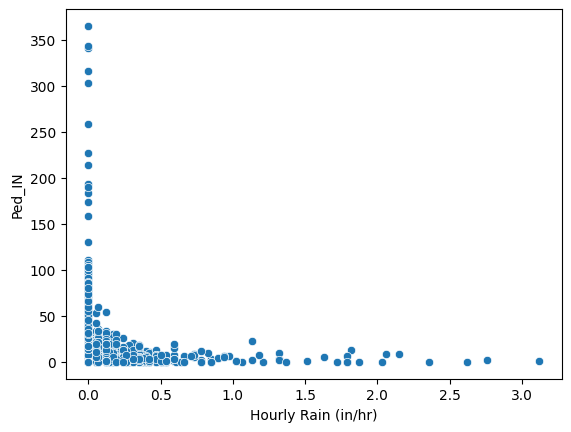

In [205]:
sns.scatterplot(data=df_master, x='Hourly Rain (in/hr)', y='Ped_IN')

<Axes: xlabel='Daily Rain (in)', ylabel='Ped_IN'>

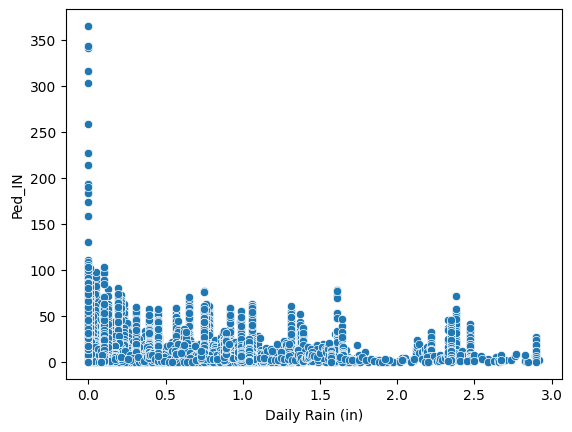

In [206]:
sns.scatterplot(data=df_master, x='Daily Rain (in)', y='Ped_IN')

<Axes: xlabel='Humidity (%)', ylabel='Ped_IN'>

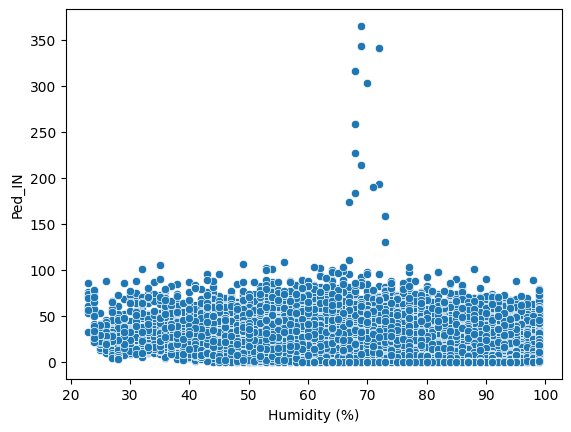

In [207]:
sns.scatterplot(data=df_master, y='Ped_IN', x='Humidity (%)')

Those outlier data at around 69% humidity as suspect as possibly all happening on the same day i.e. Porchfest anomalies.

In [208]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34333 entries, 0 to 34332
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Dt                            34333 non-null  datetime64[ns]
 1   Ped_IN                        34333 non-null  int64         
 2   Ped_OUT                       34333 non-null  int64         
 3   Outdoor Temperature (°F)      34333 non-null  float64       
 4   Feels Like (°F)               34333 non-null  float64       
 5   Dew Point (°F)                34333 non-null  float64       
 6   Wind Speed (mph)              34333 non-null  float64       
 7   Wind Gust (mph)               34333 non-null  float64       
 8   Max Daily Gust (mph)          34333 non-null  float64       
 9   Wind Direction (°)            34333 non-null  int64         
 10  Hourly Rain (in/hr)           34333 non-null  float64       
 11  Event Rain (in)             

In [209]:
df_master.head()

Dt  Ped_IN  Ped_OUT  Outdoor Temperature (°F)  \
0 2023-05-17 00:00:00       2        2                      66.9   
1 2023-05-17 00:15:00       1        3                      66.7   
2 2023-05-17 00:30:00       0        0                      64.8   
3 2023-05-17 00:45:00       0        0                      63.0   
4 2023-05-17 01:00:00       0        0                      62.2   

   Feels Like (°F)  Dew Point (°F)  Wind Speed (mph)  Wind Gust (mph)  \
0             66.9            48.2               0.0              0.0   
1             66.7            45.8               0.7              1.1   
2             64.8            45.7               0.9              2.2   
3             63.0            46.6               3.4              5.8   
4             62.2            46.8               0.0              0.0   

   Max Daily Gust (mph)  Wind Direction (°)  ...  Indoor Temperature (°F)  \
0                   0.0                 330  ...                     73.2   
1                   8.1                  25  ...                     73.2   
2                   9.2                  23  ...                     72.9   
3                  10.3                  47  ...                     72.7   
4                  10.3                  20  ...                     72.7   

   Indoor Humidity (%)  Absolute Pressure (inHg)  Indoor Feels Like (°F)  \
0                   34                     29.43                    71.8   
1                   35                     29.42                    71.9   
2                   35                     29.42                    71.5   
3                   35                     29.42                    71.3   
4                   35                     29.44                    71.3   

   Indoor Dew Point (°F)  year  month  hour  day   week_day  
0                   43.1  2023    May     0   17  Wednesday  
1                   43.9  2023    May     0   17  Wednesday  
2                   43.6  2023    May     0   17  Wednesday  
3                   43.5  2023    May     0   17  Wednesday  
4                   43.5  2023    May     1   17  Wednesday  

[5 rows x 30 columns]

In [210]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34333 entries, 0 to 34332
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Dt                            34333 non-null  datetime64[ns]
 1   Ped_IN                        34333 non-null  int64         
 2   Ped_OUT                       34333 non-null  int64         
 3   Outdoor Temperature (°F)      34333 non-null  float64       
 4   Feels Like (°F)               34333 non-null  float64       
 5   Dew Point (°F)                34333 non-null  float64       
 6   Wind Speed (mph)              34333 non-null  float64       
 7   Wind Gust (mph)               34333 non-null  float64       
 8   Max Daily Gust (mph)          34333 non-null  float64       
 9   Wind Direction (°)            34333 non-null  int64         
 10  Hourly Rain (in/hr)           34333 non-null  float64       
 11  Event Rain (in)             

### **Missing value treatment**

In [211]:
# Checking missing values
df_master.isna().sum()

Dt                              0
Ped_IN                          0
Ped_OUT                         0
Outdoor Temperature (°F)        0
Feels Like (°F)                 0
Dew Point (°F)                  0
Wind Speed (mph)                0
Wind Gust (mph)                 0
Max Daily Gust (mph)            0
Wind Direction (°)              0
Hourly Rain (in/hr)             0
Event Rain (in)                 0
Daily Rain (in)                 0
Weekly Rain (in)                0
Monthly Rain (in)               0
Total Rain (in)                 0
Relative Pressure (inHg)        0
Humidity (%)                    0
Ultra-Violet Radiation Index    0
Solar Radiation (W/m^2)         0
Indoor Temperature (°F)         0
Indoor Humidity (%)             0
Absolute Pressure (inHg)        0
Indoor Feels Like (°F)          0
Indoor Dew Point (°F)           0
year                            0
month                           0
hour                            0
day                             0
week_day      

## **Exploratory Data Analysis: Univariate**

**Let us explore the numerical variables first.**

In [212]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def histogram_boxplot(feature, figsize=(15, 10), bins="auto"):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (15, 10))
    bins: number of bins (default "auto")
    """
    f, (ax_box, ax_hist) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid
        sharex=True,  # The X-axis will be shared among all the subplots
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=figsize
    )

    # Creating the subplots
    # Boxplot will be created and the mean value of the column will be indicated using some symbol
    sns.boxplot(x=feature, ax=ax_box, showmeans=True, color='red')

    # For histogram
    sns.histplot(x=feature, kde=False, ax=ax_hist, bins=bins)
    ax_hist.axvline(np.mean(feature), color='g', linestyle='--')      # Add mean to the histogram
    ax_hist.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

    plt.show()

def histogram_boxplot(feature, figsize=(15, 10), bins="auto", hue="auto"):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (15, 10))
    bins: number of bins (default "auto")
    """
    f, (ax_box, ax_hist) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid
        sharex=True,  # The X-axis will be shared among all the subplots
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=figsize
    )

    # Creating the subplots
    # Boxplot will be created and the mean value of the column will be indicated using some symbol
    sns.boxplot(x=feature, ax=ax_box, showmeans=True, color='red', hue=hue)

    # For histogram
    sns.histplot(x=feature, kde=False, ax=ax_hist, bins=bins)
    ax_hist.axvline(np.mean(feature), color='g', linestyle='--')      # Add mean to the histogram
    ax_hist.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

    plt.show()

### **Observations on Pedestrian Counts**

#### **Identifying Porchfest data (Ped_IN outliers)**

In [213]:
#default is that all rows are NOT porchfest
df_master['PF']="no"
#isolating porchfest data
df_master.loc[(df_master['month']=='May') & (df_master['day']==11) & (df_master['hour']>12) & (df_master['hour']<20),'PF']="yes"
df_master['PF'].value_counts()

PF
no     34305
yes       28
Name: count, dtype: int64

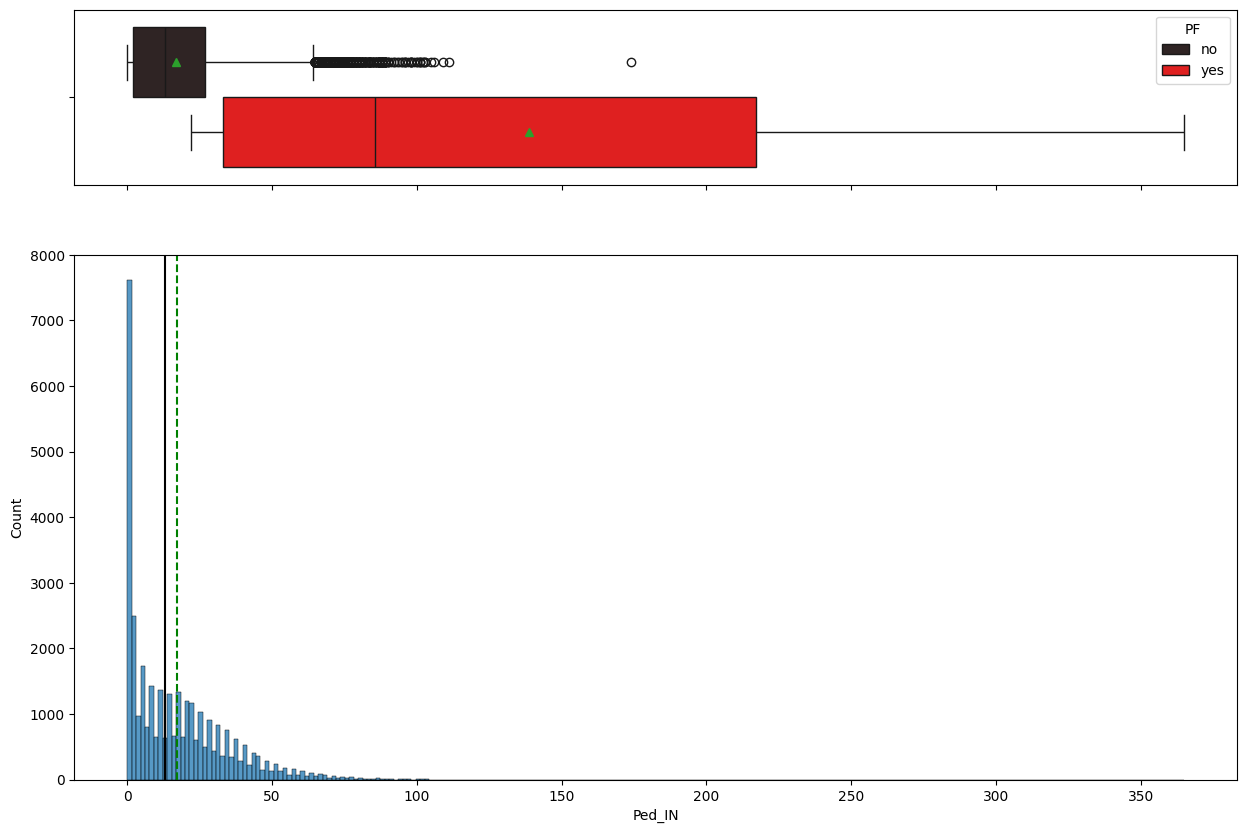

In [214]:
histogram_boxplot(df_master.Ped_IN, hue=df_master.PF)

**Observations:**
* The distribution of counts is highly right-skewed.
* The majority of the counts are less than 70.
* There are a lot of outliers in this variable.
* While most counts are at the lower end, we have observations as high as 250. Let's see where Porchfests lies (May 11, 2024, noon-6pm)

In [215]:
df_master[df_master['Ped_IN'] > 150]

Dt  Ped_IN  Ped_OUT  Outdoor Temperature (°F)  \
8862  2023-08-19 10:15:00     174       38                      72.3   
33949 2024-05-11 13:45:00     193       64                      53.6   
33950 2024-05-11 14:00:00     227       36                      56.3   
33951 2024-05-11 14:15:00     341       45                      54.9   
33952 2024-05-11 14:30:00     343       53                      56.1   
33953 2024-05-11 14:45:00     303       61                      55.9   
33954 2024-05-11 15:00:00     365       67                      54.1   
33955 2024-05-11 15:15:00     316       47                      54.3   
33956 2024-05-11 15:30:00     214       38                      53.4   
33957 2024-05-11 15:45:00     259       50                      54.1   
33958 2024-05-11 16:00:00     183       75                      53.8   
33959 2024-05-11 16:15:00     190       99                      53.1   
33960 2024-05-11 16:30:00     158       46                      53.2   

       Feels Like (°F)  Dew Point (°F)  Wind Speed (mph)  Wind Gust (mph)  \
8862              72.4            60.7               0.0              0.0   
33949             53.6            44.8               2.7              5.8   
33950             56.3            45.9               0.0              0.0   
33951             54.9            46.0               0.9              4.5   
33952             56.1            46.1               2.7              5.8   
33953             55.9            46.3               5.8              8.1   
33954             54.1            44.2               1.3              3.4   
33955             54.3            44.0               1.6              3.4   
33956             53.4            43.5               2.9              5.8   
33957             54.1            43.8               5.8              9.2   
33958             53.8            43.5               3.4              5.8   
33959             53.1            43.9               1.3              4.5   
33960             53.2            44.8               4.9              5.8   

       Max Daily Gust (mph)  Wind Direction (°)  ...  Indoor Humidity (%)  \
8862                   13.6                 231  ...                   59   
33949                  14.8                  86  ...                   43   
33950                  14.8                  73  ...                   43   
33951                  14.8                 131  ...                   43   
33952                  14.8                 102  ...                   43   
33953                  15.9                  45  ...                   44   
33954                  15.9                  45  ...                   44   
33955                  15.9                 117  ...                   44   
33956                  15.9                 110  ...                   44   
33957                  15.9                 109  ...                   44   
33958                  15.9                  72  ...                   44   
33959                  15.9                  98  ...                   44   
33960                  15.9                 169  ...                   44   

       Absolute Pressure (inHg)  Indoor Feels Like (°F)  \
8862                      29.83                    76.2   
33949                     29.82                    66.2   
33950                     29.82                    66.6   
33951                     29.81                    66.4   
33952                     29.81                    66.7   
33953                     29.81                    66.7   
33954                     29.81                    66.7   
33955                     29.80                    66.7   
33956                     29.81                    66.7   
33957                     29.80                    66.7   
33958                     29.80                    66.7   
33959                     29.80                    66.7   
33960                     29.81                    66.7   

       Indoor Dew Point (°F) 

12 of the 13 high count rows were PorchFest, from between 1 and 5pm.  The exception was a very nice day the previous August, on a sunny day.

In [216]:
df_master[df_master['Ped_IN'] ==174 ]['Solar Radiation (W/m^2)']

8862    805.6
Name: Solar Radiation (W/m^2), dtype: float64

###  **Observations on Sunshine**

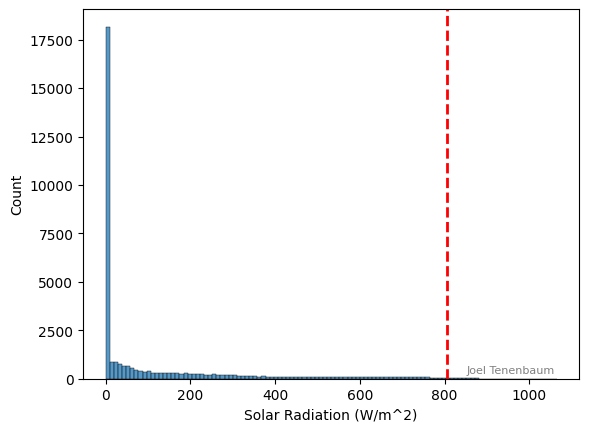

In [217]:
#histogram_boxplot(df_master['Solar Radiation (W/m^2)'])
# For histogram
sns.histplot(x=df_master['Solar Radiation (W/m^2)'], kde=False)
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)
figsize=(15, 10)
# Add median to the histogram
plt.axvline(x=805.6, color='r', linestyle='--', linewidth=2)
plt.show()


**Observations:**
* The distribution of 'Solar Radiation' is right-skewed.
* The stray August day with a ped count of over 150 was one of the sunniest days of the year. It was 72F at 10am on a Saturday.
* The Porchfest outlier days are completely overwhelming any other correlations in the data, since the Pearson correlation coefficient is not robust to outliers. A separate treatment with Porchfesh data removed will be necessary.

Text(0.95, 0.01, 'Joel Tenenbaum')

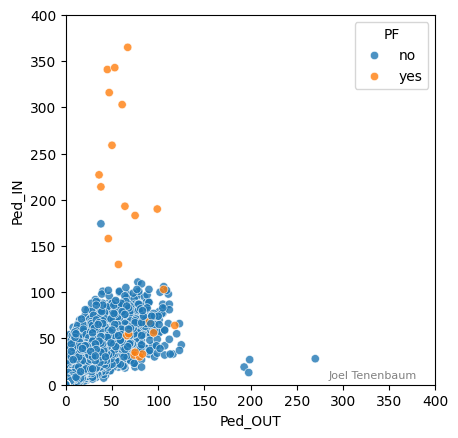

In [221]:
#The strongest correlate of Ped_In was sunshine so let's get the joint plot
# Solar Radiation (W/m^2)
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
sns.scatterplot(data=df_master, x='Ped_OUT', y='Ped_IN', hue="PF", alpha=0.8)
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)

Of course, given people's commuting patterns (see Relationship between Ped count and Hour of the day), much of the correlation may simply be people going out during daylight hours.  We check this below.

Also, what's the explanation for the outliers in Ped_OUT?

In [53]:
df_master[df_master['Ped_OUT'] > 150]

Dt  Ped_IN  Ped_OUT  Outdoor Temperature (°F)  \
12841 2023-09-30 09:15:00      28      270                      58.6   
20090 2023-12-16 18:30:00      19      193                      41.9   
20156 2023-12-17 11:15:00      30      696                      48.9   
20157 2023-12-17 11:30:00      26      609                      48.9   
29393 2024-03-24 11:15:00      27      199                      32.7   
29394 2024-03-24 11:30:00      13      198                      33.6   

       Feels Like (°F)  Dew Point (°F)  Wind Speed (mph)  Wind Gust (mph)  \
12841             58.6            57.5               0.9              1.1   
20090             41.9            37.1               0.0              0.0   
20156             48.9            45.5               0.0              0.0   
20157             48.9            45.5               1.3              4.5   
29393             32.7            16.6               0.0              0.0   
29394             33.6            16.5               2.2              3.4   

       Max Daily Gust (mph)  Wind Direction (°)  ...  Indoor Humidity (%)  \
12841                   6.9                  17  ...                   64   
20090                  14.8                 103  ...                   44   
20156                  12.5                  85  ...                   44   
20157                  12.5                 141  ...                   44   
29393                  26.2                 343  ...                   39   
29394                  26.2                 323  ...                   38   

       Absolute Pressure (inHg)  Indoor Feels Like (°F)  \
12841                     30.14                    66.7   
20090                     30.54                    63.7   
20156                     30.36                    62.4   
20157                     30.34                    62.6   
29393                     30.21                    61.5   
29394                     30.22                    61.5   

       Indoor Dew Point (°F)  year      month  hour  day  week_day  PF  
12841                   54.1  2023  September     9   30  Saturday  no  
20090                   41.4  2023   December    18   16  Saturday  no  
20156                   40.2  2023   December    11   17    Sunday  no  
20157                   40.4  2023   December    11   17    Sunday  no  
29393                   36.3  2024      March    11   24    Sunday  no  
29394                   35.7  2024      March    11   24    Sunday  no  

[6 rows x 31 columns]

### **Ped_OUT outliers/Special Events**

* **Dec 17, 2023 at 11am** is exactly when the **Jingle Bell Run** started.  The Run goes right past the sensor at Cedar St along the Community Path.

* **Marc 11, 2024** was the **Race of Ireland**, which covers an identical route.

* **Dec 16 at 6pm** may have been the **Illuminations Bike Tour**.

* **Sept 30, 9am** was the **Somerville 5K**, also starting from Davis.

Let's expand out PF variable to include these events

In [223]:
df_master.loc[df_master['Ped_OUT']> 150 ,'PF']="other special"
df_master['PF'].value_counts()

PF
no               34299
yes                 28
other special        6
Name: count, dtype: int64

Text(0.95, 0.01, 'Joel Tenenbaum')

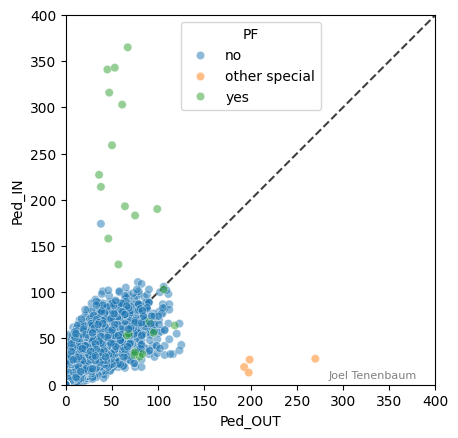

In [226]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
sns.scatterplot(data=df_master, x='Ped_OUT', y='Ped_IN', hue="PF", alpha=0.5)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)

### **Visualizing a Few Special Events**

#### **Porchfest, May 11, 2024**

In [56]:
start_date = '2024-05-01'
end_date='2024-05-20'
mask = (df_master['Dt'] >= start_date) & (df_master['Dt'] <= end_date)
filtered_df = df_master.loc[mask]

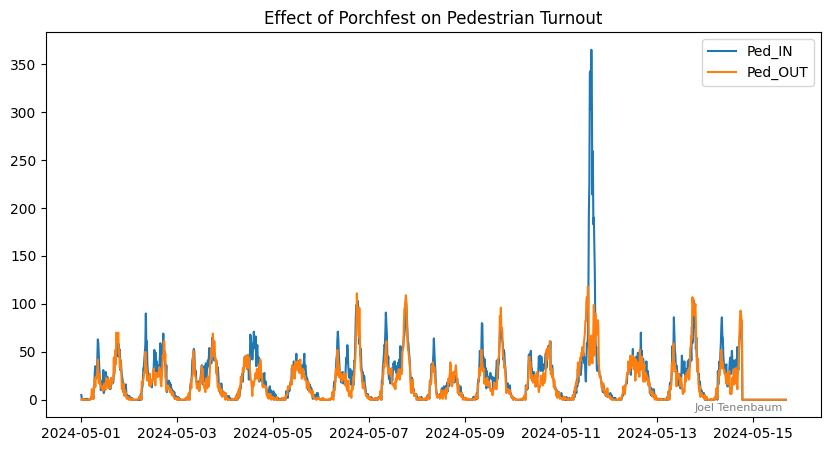

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(filtered_df['Dt'], filtered_df['Ped_IN'], label="Ped_IN")
plt.plot(filtered_df['Dt'], filtered_df['Ped_OUT'], label="Ped_OUT")
plt.title("Effect of Porchfest on Pedestrian Turnout")
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)
plt.legend()

#### **Jingle Bell Run, Dec 17, 2023**

In [58]:
start_date = '2023-12-10'
end_date='2023-12-20'
mask = (df_master['Dt'] >= start_date) & (df_master['Dt'] <= end_date)
filtered_df = df_master.loc[mask]

Text(0.95, 0.01, 'Joel Tenenbaum')

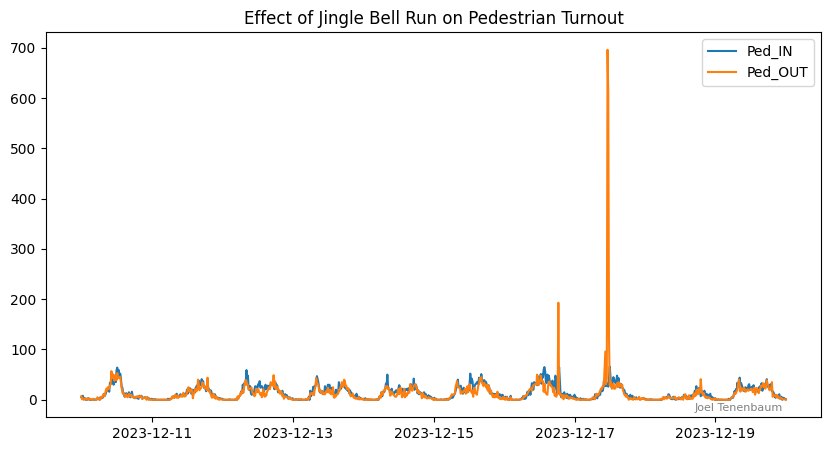

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(filtered_df['Dt'], filtered_df['Ped_IN'], label="Ped_IN")
plt.plot(filtered_df['Dt'], filtered_df['Ped_OUT'], label="Ped_OUT")
plt.title("Effect of Jingle Bell Run on Pedestrian Turnout")
plt.legend()
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)

#### **Effect of Somerville Community Path extension, June 10, 2023**

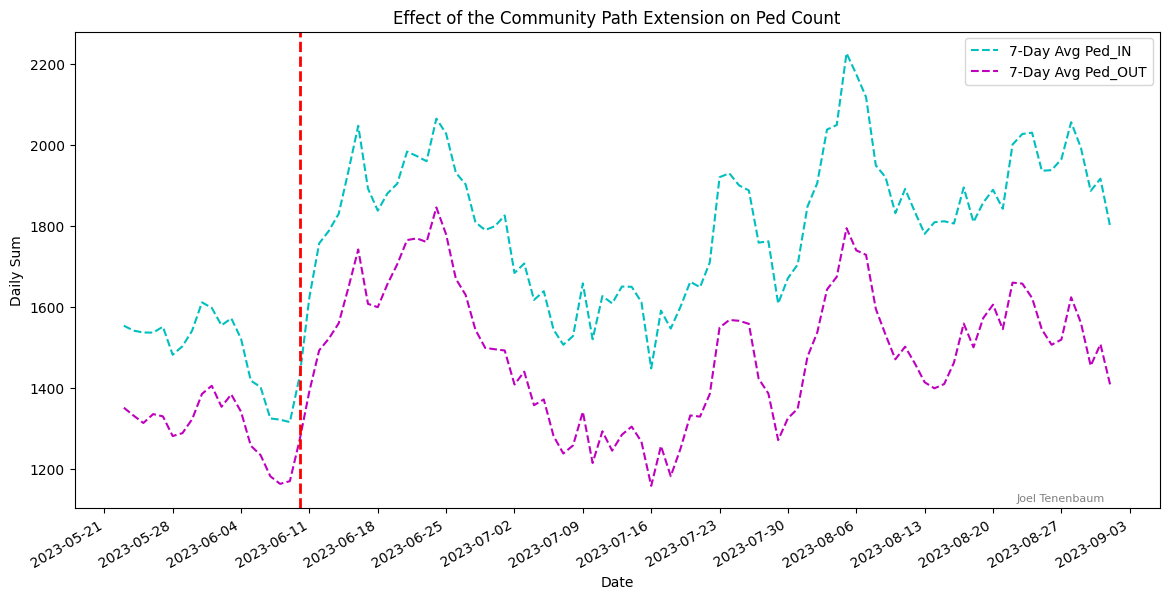

In [60]:
# Convert Dt column to datetime if not already
df_master['Dt'] = pd.to_datetime(df_master['Dt'])

# Filter the DataFrame for the desired date range
start_date = '2023-03-03'
end_date = '2023-09-01'
mask = (df_master['Dt'] >= start_date) & (df_master['Dt'] <= end_date)
df_filtered = df_master.loc[mask]

# Set the Dt column as the index, retaining the 'Dt' column
df_filtered.set_index('Dt', inplace=True, drop=False)

# Resample the data to daily frequency and sum the values for each day
daily_data = df_filtered.resample('D', on='Dt').sum()

daily_data['Ped_IN_7day_avg'] = daily_data['Ped_IN'].rolling(window=7).mean()
daily_data['Ped_OUT_7day_avg'] = daily_data['Ped_OUT'].rolling(window=7).mean()

# Plot the resampled data
plt.figure(figsize=(14, 7))
#plt.plot(daily_data.index, daily_data['Ped_IN'], label='Daily Ped_IN')
#plt.plot(daily_data.index, daily_data['Ped_OUT'], label='Daily Ped_OUT')
plt.plot(daily_data.index, daily_data['Ped_IN_7day_avg'], linestyle='--', color='c', label='7-Day Avg Ped_IN')
plt.plot(daily_data.index, daily_data['Ped_OUT_7day_avg'], linestyle='--', color='m', label='7-Day Avg Ped_OUT')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Daily Sum')
plt.title('Effect of the Community Path Extension on Ped Count')
plt.legend()

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.axvline(x=pd.to_datetime('2023-06-10'), color='r', linestyle='--', linewidth=2)
# Show the plot
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)
plt.show()



**Now, let's explore the categorical variables.**

In [61]:
def bar_perc(data, z):
    total = len(data[z]) # Length of the column
    plt.figure(figsize = (15, 5))

    # Convert the column to a categorical data type
    data[z] = data[z].astype('category')

    ax = sns.countplot(x=z, data=data, palette='Paired', order=data[z].value_counts().index)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total) # Percentage of each class
        x = p.get_x() + p.get_width() / 2 - 0.05                    # Width of the plot
        y = p.get_y() + p.get_height()                              # Height of the plot
        ax.annotate(percentage, (x, y), size = 12)                  # Annotate the percentage

    plt.show()                                                      # Display the plot

## **Relationship between ped_IN and time based variables**

### **Ped Count across Months**

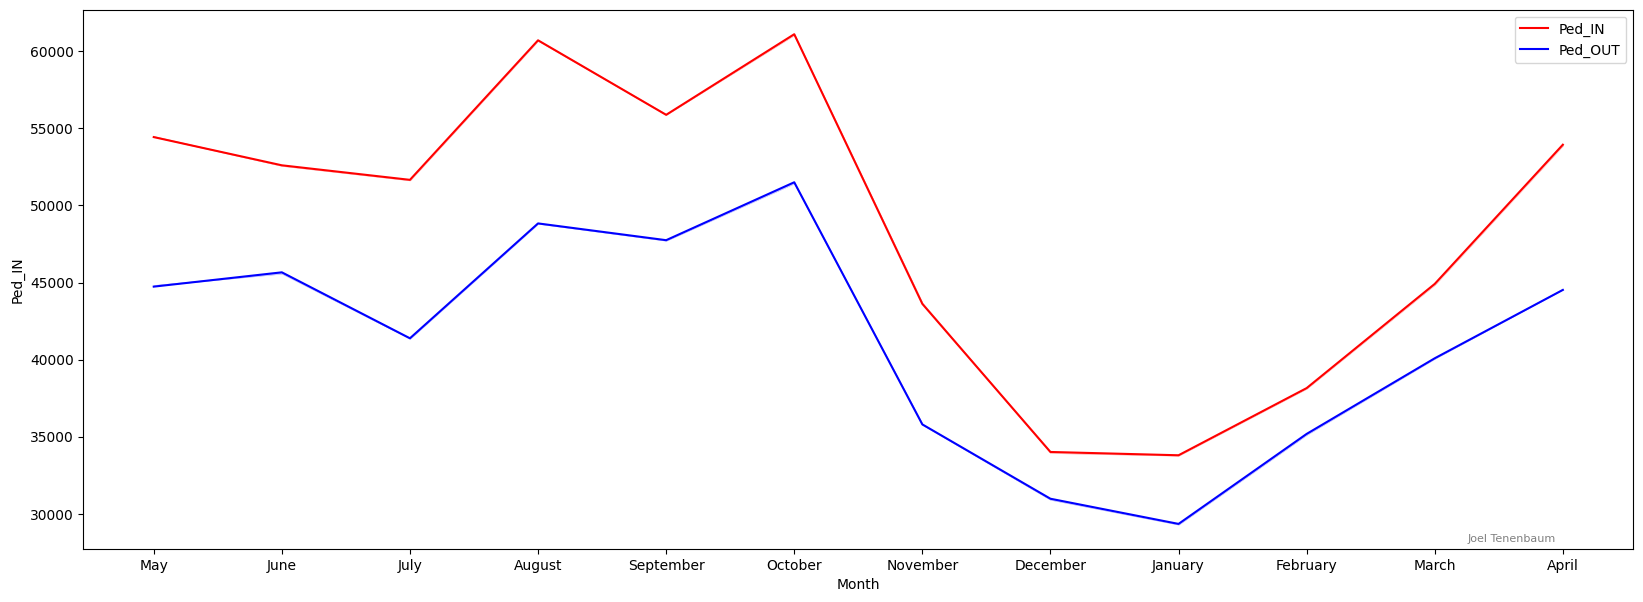

In [62]:
cats = df_master.month.unique().tolist()
df_master.month = pd.Categorical(df_master.month, ordered = True, categories = cats)
plt.figure(figsize = (20, 7))
sns.lineplot(x = "month", y = "Ped_IN", data = df_master, ci = 0, color = "RED", estimator = 'sum', label="Ped_IN")
plt.ylabel('Ped_IN')
sns.lineplot(x = "month", y = "Ped_OUT", data = df_master, ci = 0, color = "BLUE", estimator = 'sum', label="Ped_OUT")
plt.xlabel('Month')
plt.legend()
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)
plt.show()

**Observations:**
* Seasonality of the data is obvious.
* Dip in September may have been due to poor weather this particularl year (2023) while October's may have been better.
* Given temperature, precipitation, and sunlight variations by season, we expect seasonal ped count variations might be entirely accounted for by weather (See: below)

### **Ped_IN vs Days of the Month**

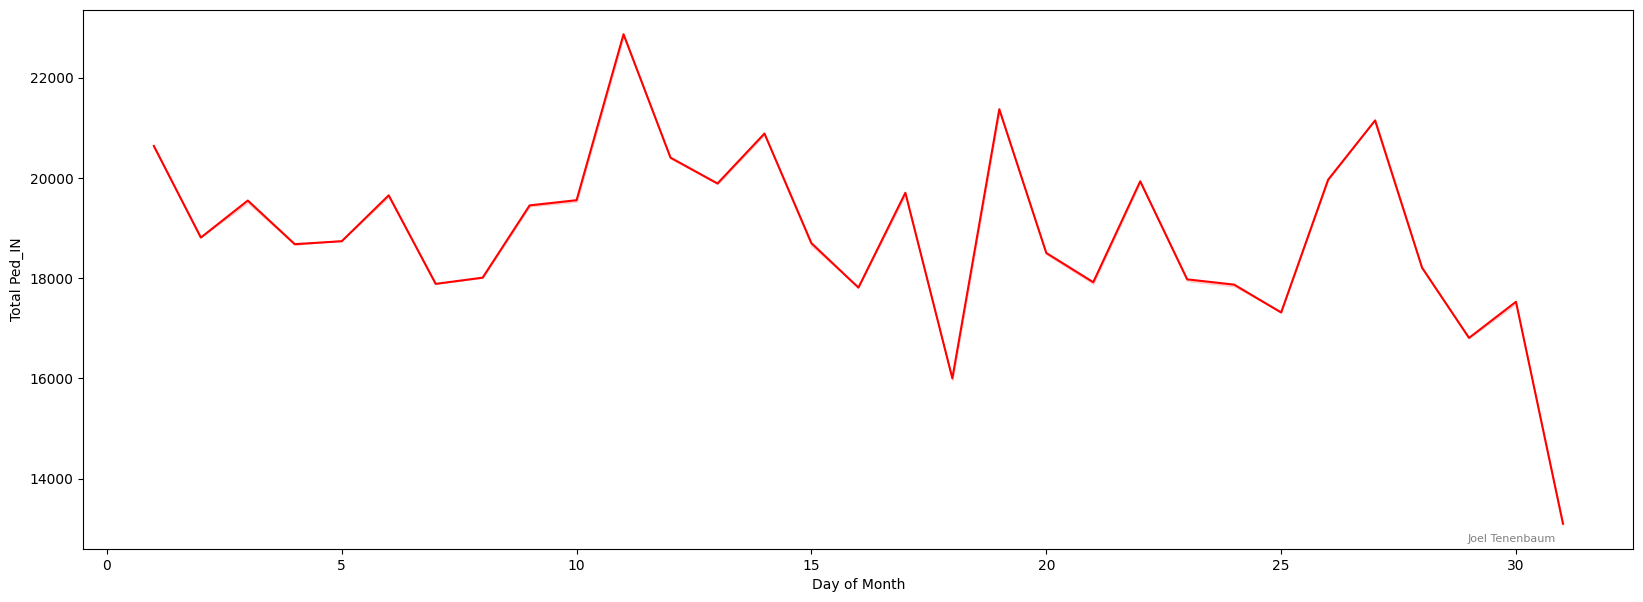

In [63]:
plt.figure(figsize = (20, 7))
sns.lineplot(x = "day", y = "Ped_IN", estimator = 'sum', ci = 0, data = df_master, color = "RED")
plt.ylabel('Total Ped_IN')
plt.xlabel('Day of Month')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)
plt.show()

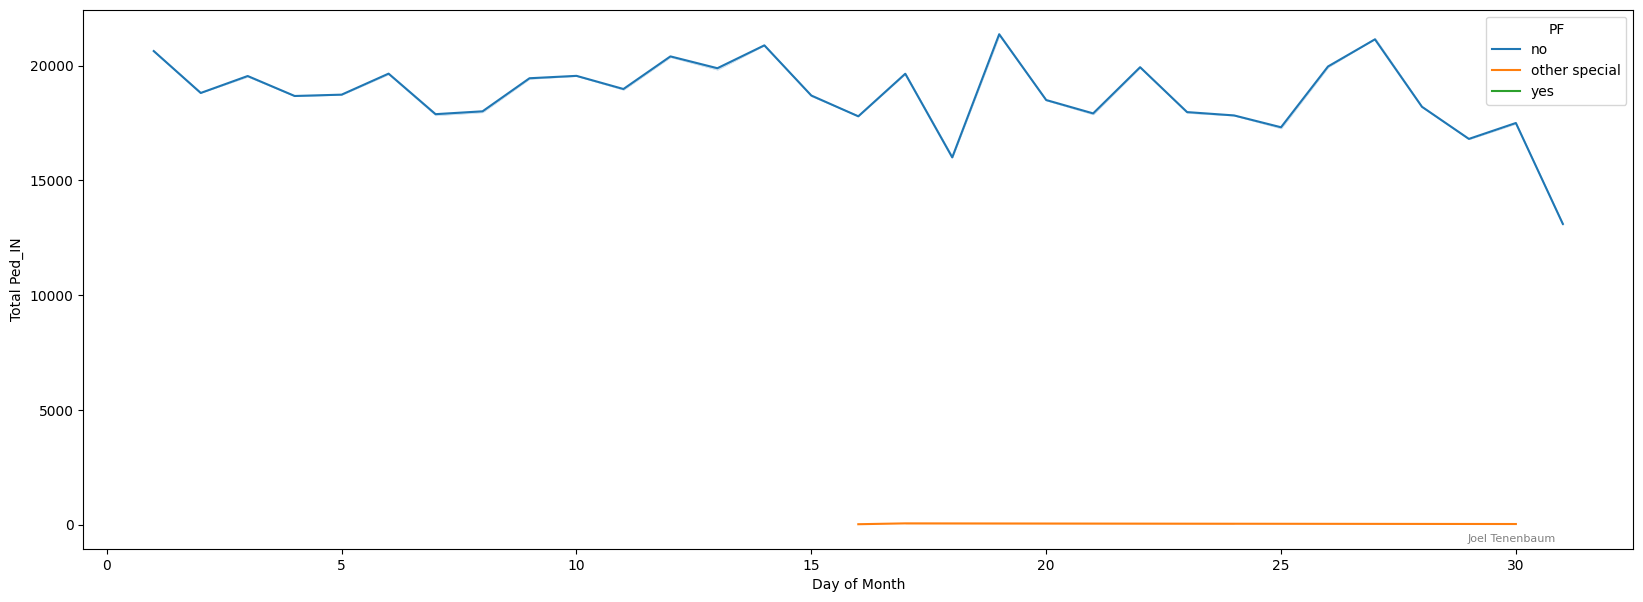

In [64]:
plt.figure(figsize = (20, 7))
sns.lineplot(x = "day", y = "Ped_IN", estimator = 'sum', ci = 0, data = df_master, color = "RED", hue="PF")
plt.ylabel('Total Ped_IN')
plt.xlabel('Day of Month')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)
plt.show()

**Observations:**
* Number of pedestrians for 31 might be low because not all months have the 31st day.
* Bump at 11th of the month was due to Porchfest.

### **Peds across Weekdays**

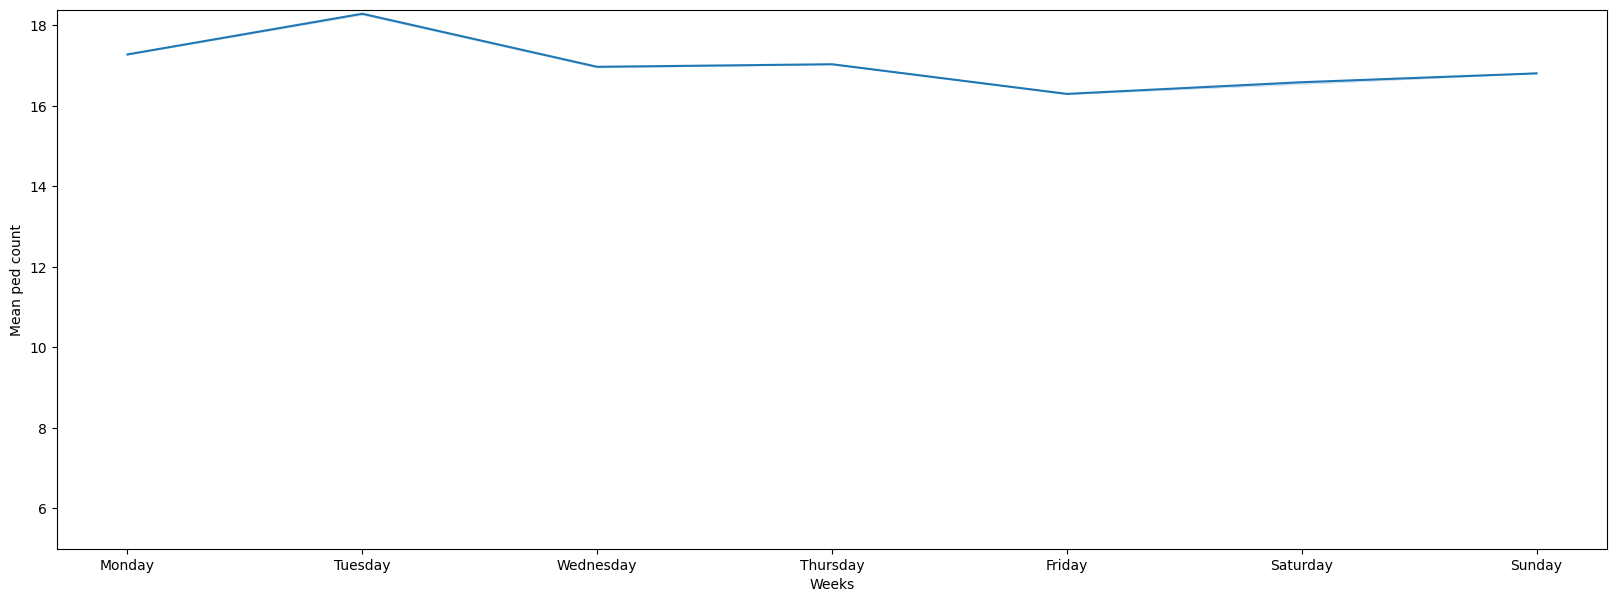

In [65]:
cats = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
df_master.week_day = pd.Categorical(df_master.week_day, ordered = True, categories = cats)
plt.figure(figsize = (20, 7))
sns.lineplot(x = "week_day", y = "Ped_IN", ci = 0, data = df_master)
plt.ylabel('Mean ped count')
plt.ylim(bottom=5)
plt.xlabel('Weeks')
plt.show()

In [66]:
df_master['week_day'].value_counts()

week_day
Wednesday    4964
Monday       4940
Sunday       4913
Thursday     4882
Tuesday      4879
Friday       4879
Saturday     4876
Name: count, dtype: int64

**Observations:**
* Note: graph does not start at 0, so differences look larger than they are here. The weekend dropoff merits further exploration, as more people have free time on weekends.
* Curiously, number of data points are not equal by day of the week.  At the extremes, we have only 4876 Saturday data points but 4964 Wednesday points, a difference of 88 points.  In 15-minute intervals, we get 96 samples per day so this difference is explained in having not started our sample one day of the week before our last sample. (e.g. Sun->Sat would give complete weeks.)

### **How Hour of the Day Affects Ped_IN and Weather Variables**

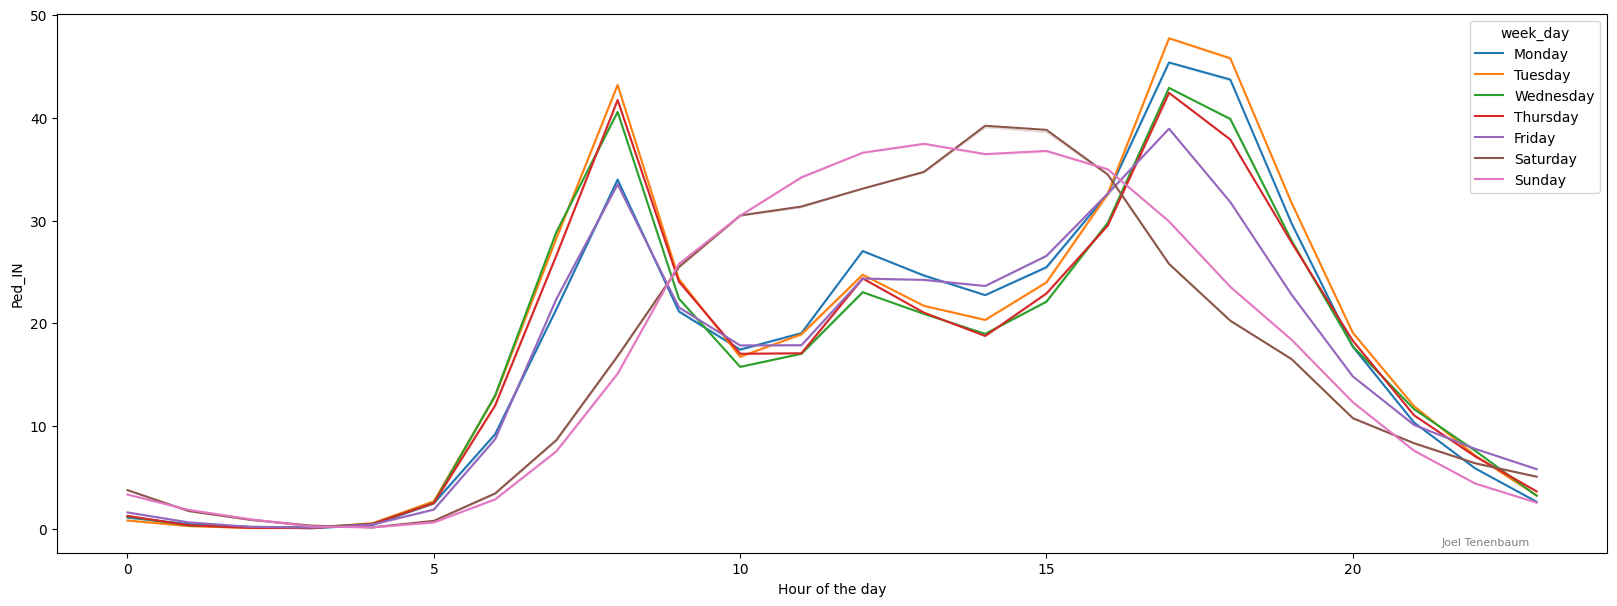

In [67]:
plt.figure(figsize = (20, 7))
sns.lineplot(x = "hour", y = "Ped_IN", ci = 0, data = df_master, hue = 'week_day')
plt.ylabel('Ped_IN')
plt.xlabel('Hour of the day')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)
plt.show()

#### **24-Hour Cycles in Weather Variables**

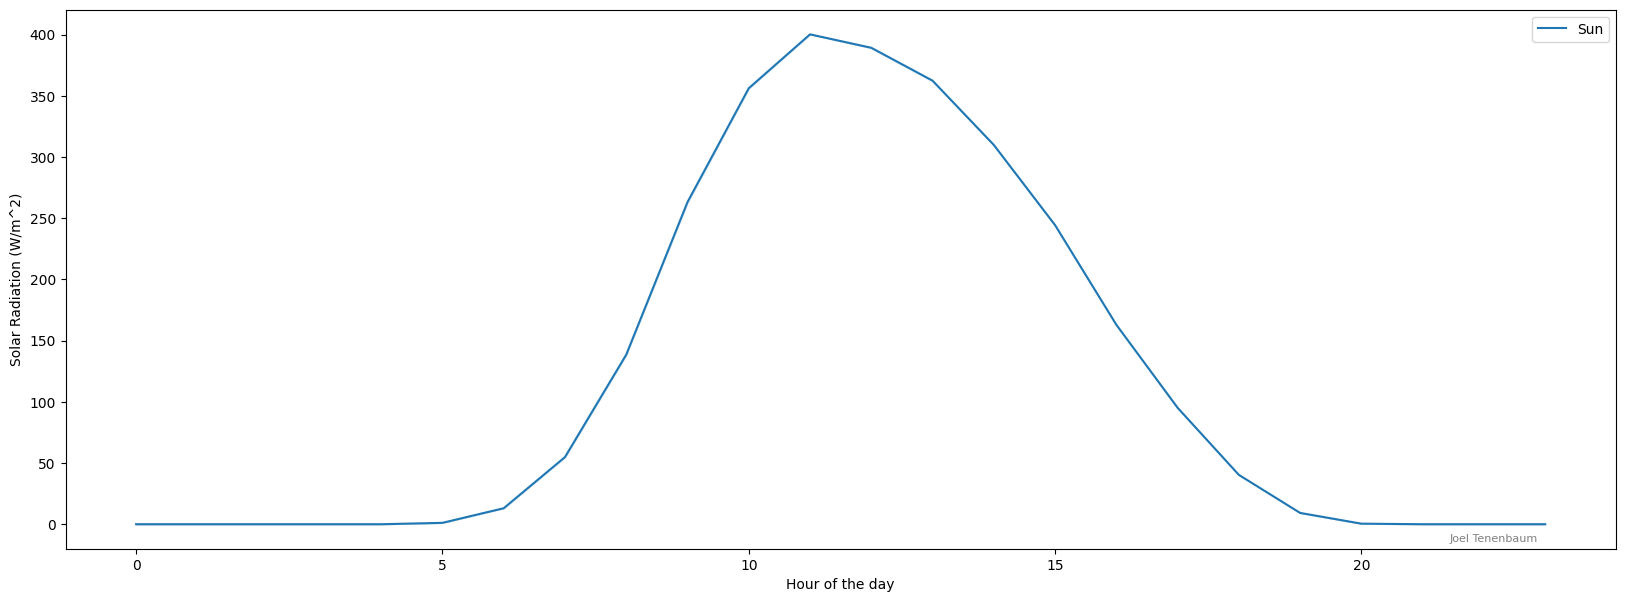

In [68]:
plt.figure(figsize = (20, 7))
sns.lineplot(x = "hour", y = "Solar Radiation (W/m^2)", ci = 0, data = df_master, label="Sun")
plt.legend()
plt.xlabel('Hour of the day')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)
plt.show()

<Axes: xlabel='hour', ylabel='Humidity (%)'>

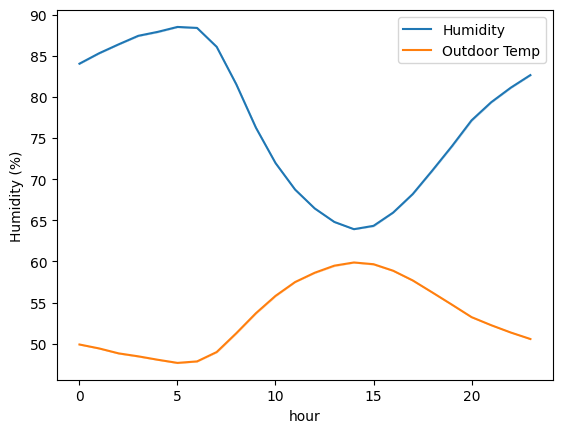

In [69]:
sns.lineplot(x = "hour", y = "Humidity (%)", ci = 0, data = df_master, label="Humidity")
sns.lineplot(x = "hour", y = "Outdoor Temperature (°F)", ci = 0, data = df_master, label="Outdoor Temp")

### Heatmap - Weekday vs Hour

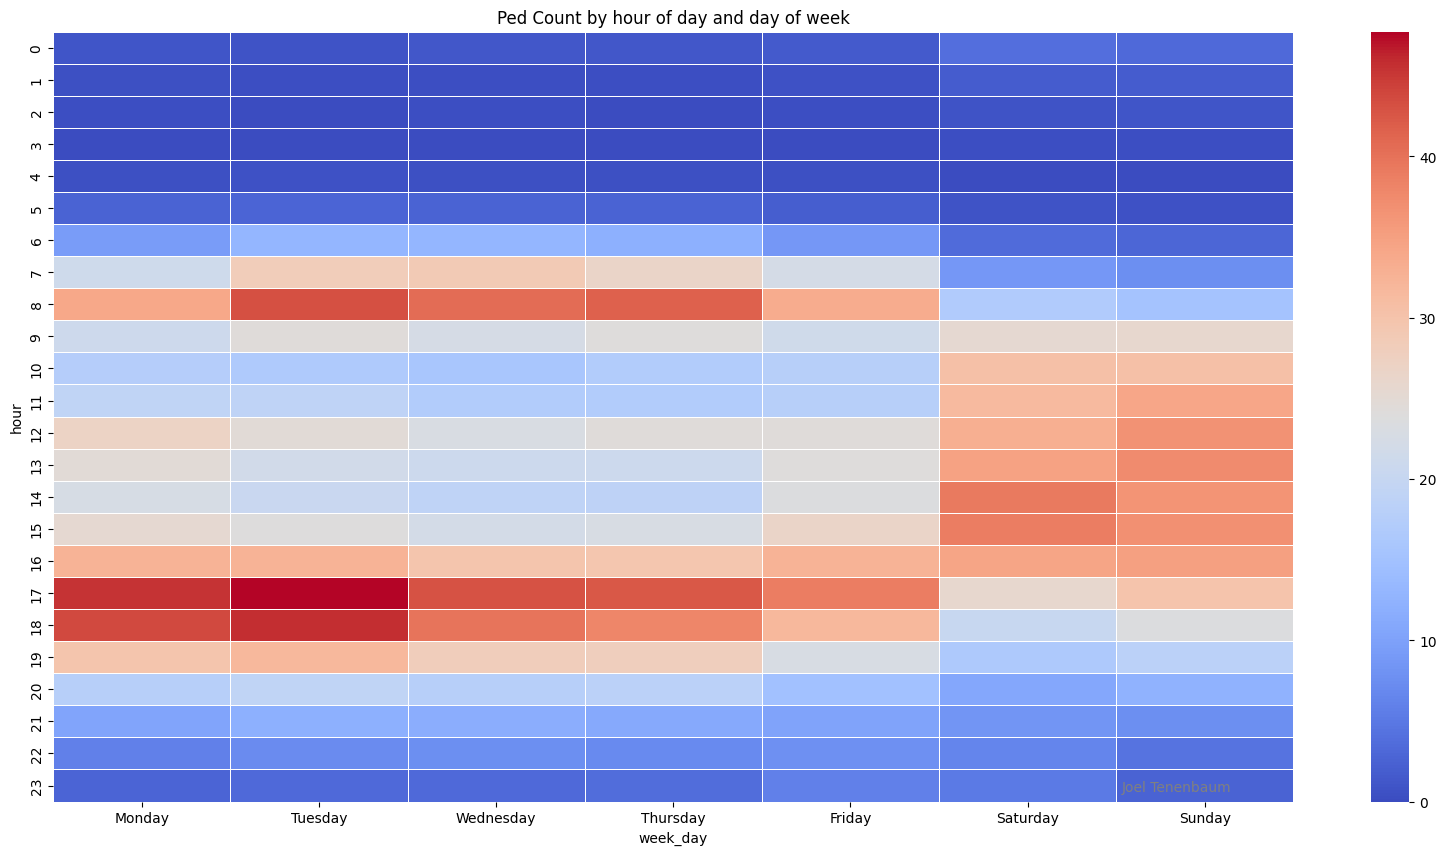

In [70]:
df_hm = df_master.pivot_table(index = 'hour', columns = 'week_day', values = 'Ped_IN')

# Draw a heatmap
plt.figure(figsize = (20, 10)) # To resize the plot
sns.heatmap(df_hm,  fmt = "d", cmap = 'coolwarm', linewidths = .5, vmin = 0)
plt.title('Ped Count by hour of day and day of week')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=10, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)
plt.show()

**Observations:**

* The extra traffic on weekdays comes almost entirely during morning and evening rush hours (8am and 6pm, respectively).  There is also a small bump in pedestrian traffic for lunch.
* The post-COVID 3-day in-office work week shows in the lighter overall Monday and Friday. Note also that on Monday, people come in an hour later and on Friday they leave an hour earlier.
* The effect of warm temperatures, sunlight, and low humidity on increasing ped count might be entirely artifacts of how these variables line up with the weather cycles of a 24-hour day, given that people commute during daytime.  Since commuting patterns and work schedules crush other effects, we'll have to control for them.

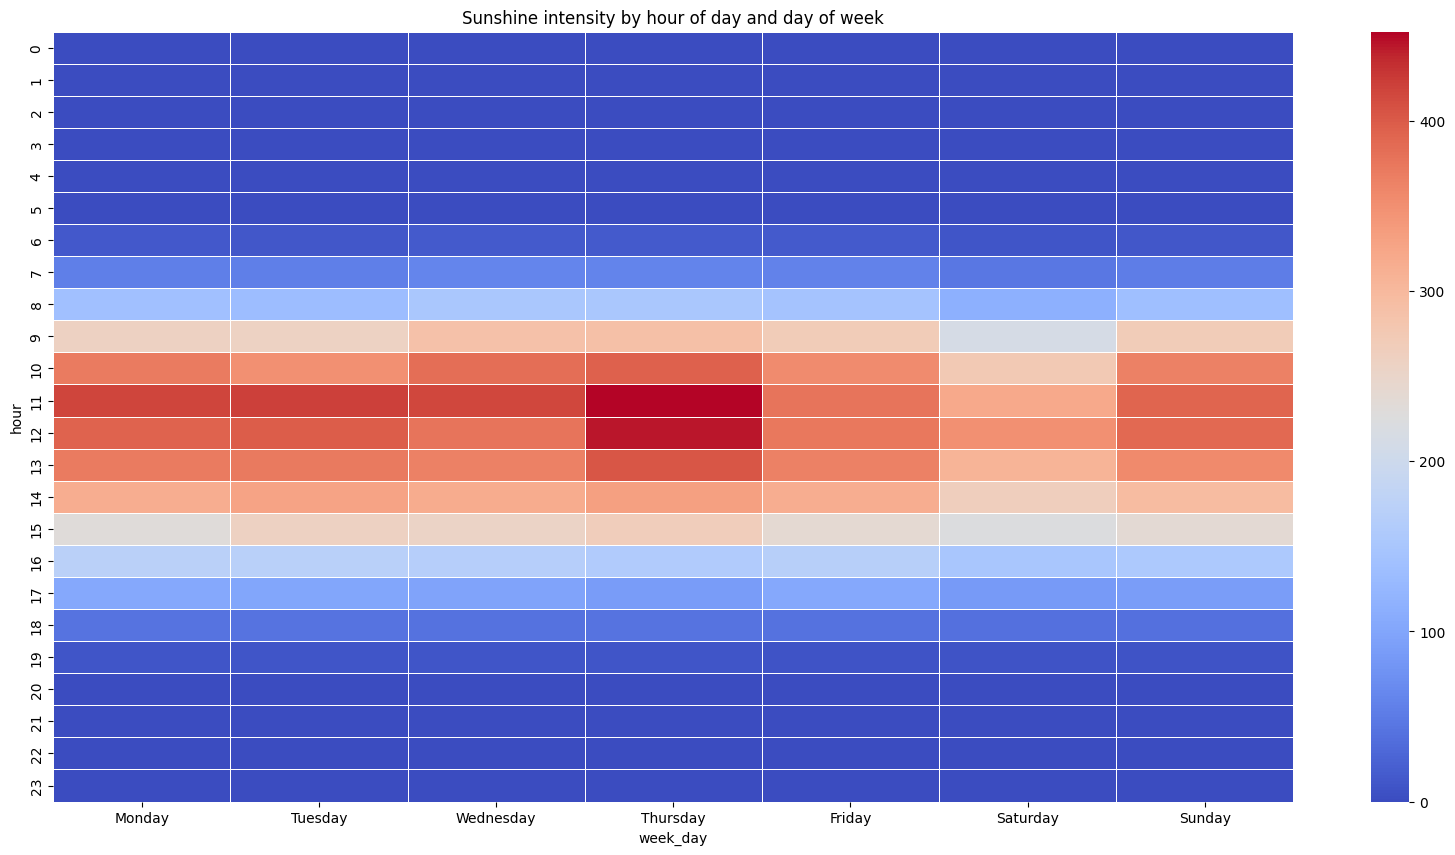

In [71]:
df_hm = df_master.pivot_table(index = 'hour', columns = 'week_day', values = 'Solar Radiation (W/m^2)')

# Draw a heatmap
plt.figure(figsize = (20, 10)) # To resize the plot
sns.heatmap(df_hm,  fmt = "d", cmap = 'coolwarm', linewidths = .5, vmin = 0)
plt.title('Sunshine intensity by hour of day and day of week')
plt.show()

## **New Treatment with Outliers Removed/Time Of Day Controlled For**


In [72]:
#locating non-porchest points at peak hours to control for confounding effects of time of day on
#humidity, sun, and temp
weekday = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday']
weekend = ['Saturday', 'Sunday']
df_master=df_master[df_master["PF"]=='no']#remove outliers
df_weekday=df_master[df_master['week_day'].isin(weekday)]
df_weekend=df_master[df_master['week_day'].isin(weekend)]
df_treated_weekday=df_weekday[(df_master["hour"]>18) & (df_master["hour"]<20)]#weekday peak
df_treated_weekend=df_weekend[(df_master["hour"]>18) & (df_master["hour"]<20)]#weekend peak

#### **Weekday Peak Hour Correlations**

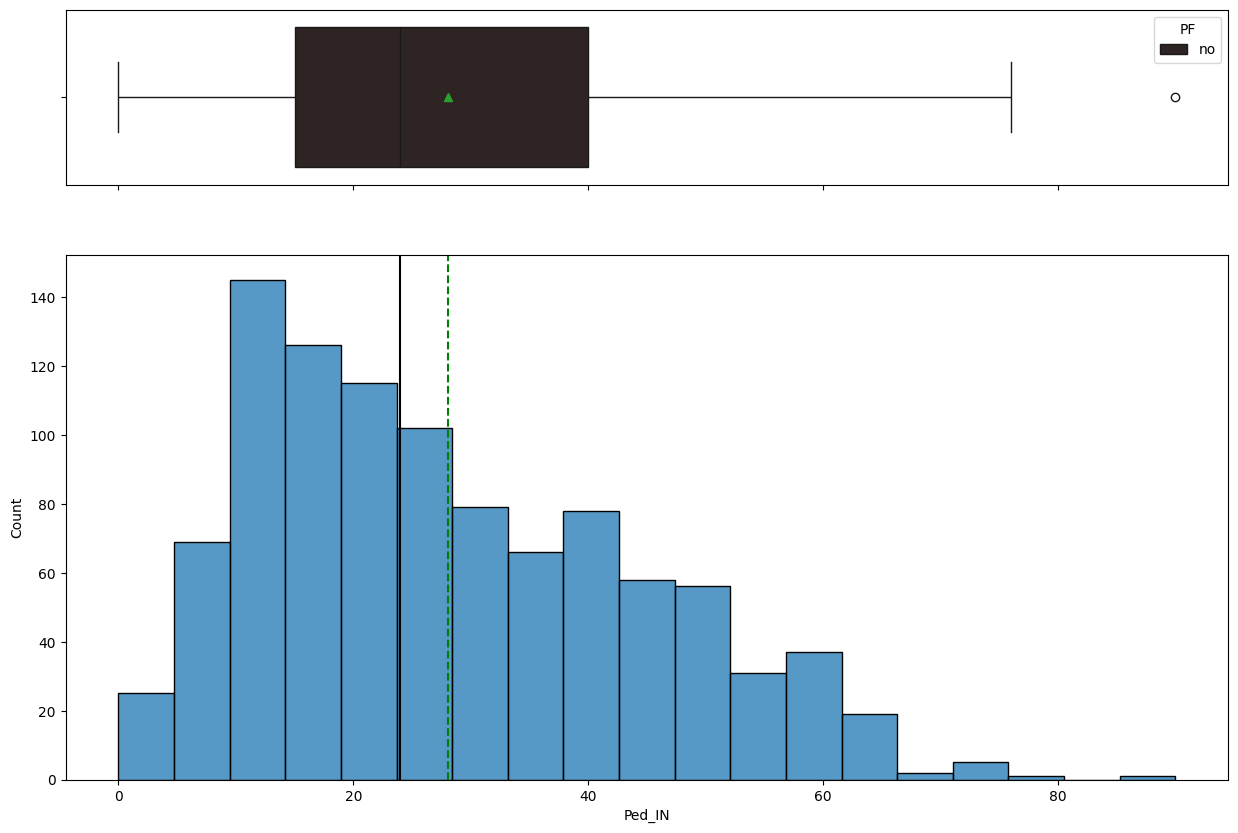

In [73]:
histogram_boxplot(df_treated_weekday.Ped_IN, hue=df_treated_weekday.PF)

In [225]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 120)
ax.set_ylim(0, 120)
sns.scatterplot(x=df_treated_weekday['Ped_OUT'], y=df_treated_weekday['Ped_IN'], alpha=.3)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.title('Special event outliers removed')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)


Text(0.95, 0.01, 'Joel Tenenbaum')

In [75]:
#sns.scatterplot(x=df_treated_weekday['Solar Radiation (W/m^2)'], y=df_treated_weekday['Ped_IN'])
sns.lmplot(data=df_treated_weekday, x='Solar Radiation (W/m^2)', y='Ped_IN', line_kws={'color':'red'})
plt.title('Effect of Sun on Weekday turnout: 6-8pm')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)

Text(0.95, 0.01, 'Joel Tenenbaum')

Text(0.95, 0.01, 'Joel Tenenbaum')

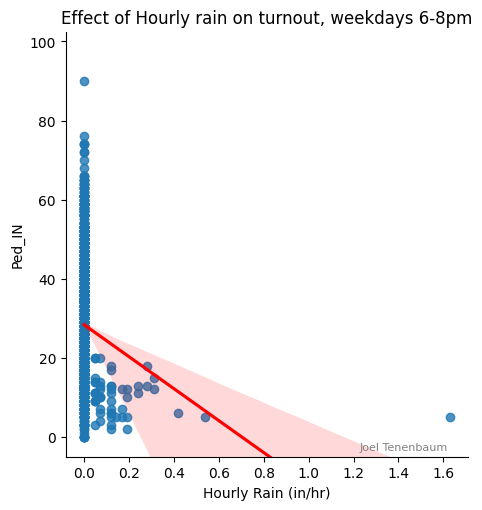

In [76]:
sns.lmplot(data=df_treated_weekday, x='Hourly Rain (in/hr)', y='Ped_IN', line_kws={'color':'red'})
plt.ylim(bottom=-5)
plt.title('Effect of Hourly rain on turnout, weekdays 6-8pm')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)

Text(0.95, 0.01, 'Joel Tenenbaum')

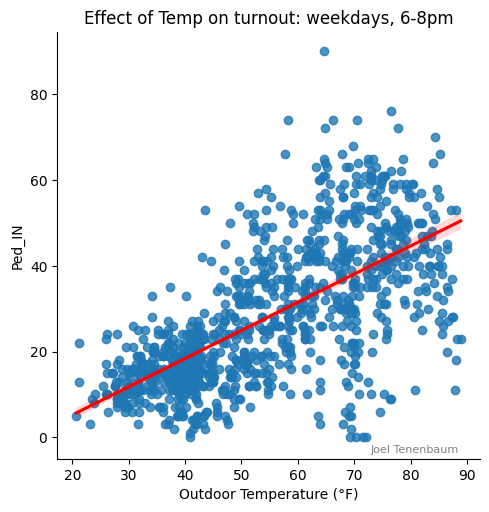

In [77]:
sns.lmplot(data=df_treated_weekday, x='Outdoor Temperature (°F)', y='Ped_IN', line_kws={'color':'red'})
plt.ylim(bottom=-5)
plt.title('Effect of Temp on turnout: weekdays, 6-8pm')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)

Text(0.95, 0.01, 'Joel Tenenbaum')

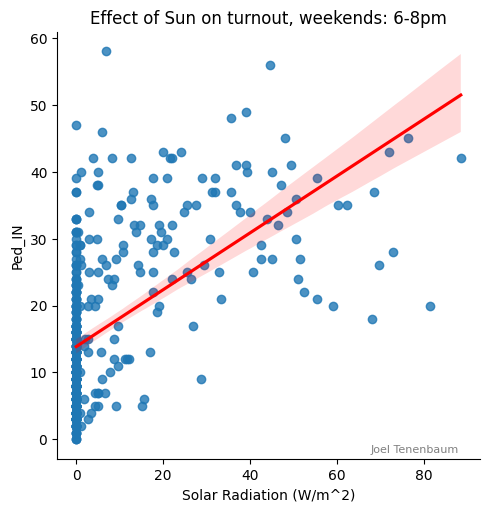

In [78]:
#sns.scatterplot(x=df_treated_morning['Solar Radiation (W/m^2)'], y=df_treated_morning['Ped_IN'])
sns.lmplot(data=df_treated_weekend, x='Solar Radiation (W/m^2)', y='Ped_IN', line_kws={'color':'red'})
plt.title('Effect of Sun on turnout, weekends: 6-8pm')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)

Text(0.95, 0.01, 'Joel Tenenbaum')

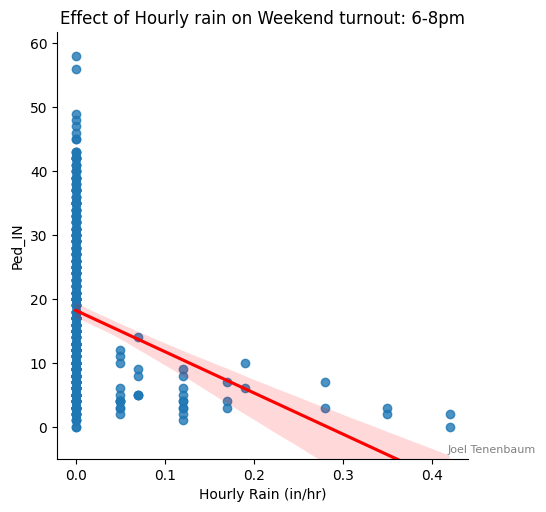

In [79]:
sns.lmplot(data=df_treated_weekend, x='Hourly Rain (in/hr)', y='Ped_IN', line_kws={'color':'red'})
plt.ylim(bottom=-5)
plt.title('Effect of Hourly rain on Weekend turnout: 6-8pm')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='left', va='bottom', transform=plt.gca().transAxes)

In [80]:
sns.lmplot(data=df_treated_weekend, x='Outdoor Temperature (°F)', y='Ped_IN', line_kws={'color':'red'})
plt.title('Effect of Temp on Weekend turnout: 6-8pm')
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)

Text(0.95, 0.01, 'Joel Tenenbaum')

####**Correlation heatmap with outliers removed, Constant Time of Day**

In [81]:
corr=df_treated_weekday[num_cols].corr()
# Plot the heatmap
plt.figure(figsize = (14, 10))
sns.heatmap(corr, annot = True, cmap = 'coolwarm',
        fmt = ".1f",
        xticklabels = corr.columns,
        yticklabels = corr.columns)
plt.text(0.95, 0.01, 'Joel Tenenbaum', fontsize=8, color='gray',
         ha='right', va='bottom', transform=plt.gca().transAxes)

Text(0.95, 0.01, 'Joel Tenenbaum')

In [82]:
corr=df_treated_weekend[num_cols].corr()
# Plot the heatmap
plt.figure(figsize = (14, 10))
sns.heatmap(corr, annot = True, cmap = 'coolwarm',
        fmt = ".1f",
        xticklabels = corr.columns,
        yticklabels = corr.columns)

<Axes: >

#### **Observations**
* Having checked peak hours in the morning and evening, we can see that sunshine and warmth really brings people out while hourly rain keeps them in. We note that wind or barometric pressure might *seem* to keep people in, both of these effects may be due to lower temperatures alone.

 Both of these effects are more prominent for weekend traffic, which is more optional and recreational, than weekday traffic, when people have to get to work and are only deciding *how* they are doing to get there.

#### **Time of Day Peds Most Sensitive to Weather (weekday)**
Can we find the time of day when sunshine is *most* correlated with pedestrian traffic?  

In [83]:
morn_corr={}
for k in range(1,24):
  df_hour=df_weekday[df_weekday["hour"]==k]#made a dataframe looking only at kth hour of the day
  morn_corr[k]=df_hour['Ped_IN'].corr(df_hour['Solar Radiation (W/m^2)'])
  print(k, '\t', df_hour['Ped_IN'].corr(df_hour['Solar Radiation (W/m^2)']))
plt.figure()

plt.plot(list(morn_corr.keys()), list(morn_corr.values()), 'bx-')

plt.xlabel("Hour of the day")

plt.ylabel("Correlation of sunlight with Ped_IN")
plt.ylim(bottom=0)
plt.show()

1 	 nan
2 	 nan
3 	 nan
4 	 nan
5 	 0.35186411020585556
6 	 0.3404912383326215
7 	 0.2875383961885317
8 	 0.23155984631148493
9 	 0.37035812625202663
10 	 0.3845097113977317
11 	 0.28052452546868845
12 	 0.4493177848334689
13 	 0.42018393112900393
14 	 0.34242909632586094
15 	 0.258056911286747
16 	 0.1895033171216257
17 	 0.2158702438355101
18 	 0.33553167797294536
19 	 0.4805431196639523
20 	 0.35313716163538333
21 	 nan
22 	 nan
23 	 nan


9AM, noon, and 7PM are the times when sunlight matters the most for pedestrian traffic. Doing a similiar analysis for **Outdoor Temperature (°F)**

1 	 0.1369113030212422
2 	 0.030205633211130102
3 	 0.14148683331509718
4 	 0.06131456735359947
5 	 0.15935772762271916
6 	 0.3234151132607249
7 	 0.3475303468942572
8 	 0.32031339095075023
9 	 0.44670271653433485
10 	 0.3212566277430671
11 	 0.12438999622276743
12 	 0.2152697136666937
13 	 0.20056131364244814
14 	 0.20173959967348484
15 	 0.15634367418204234
16 	 0.17116184679612276
17 	 0.3514630963484729
18 	 0.5195458306488225
19 	 0.6645953924320289
20 	 0.6740319822732352
21 	 0.633657228720545
22 	 0.50280373814078
23 	 0.43037703222402574


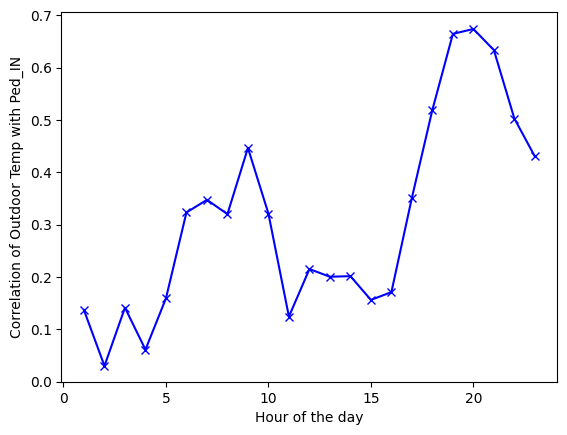

In [84]:
morn_corr={}
for k in range(1,24):
  df_hour=df_weekday[df_weekday["hour"]==k]#made a dataframe
  morn_corr[k]=df_hour['Ped_IN'].corr(df_hour['Outdoor Temperature (°F)'])
  print(k, '\t', df_hour['Ped_IN'].corr(df_hour['Outdoor Temperature (°F)']))
plt.figure()

plt.plot(list(morn_corr.keys()), list(morn_corr.values()), 'bx-')

plt.xlabel("Hour of the day")

plt.ylabel("Correlation of Outdoor Temp with Ped_IN")
plt.ylim(bottom=0)
plt.show()

Temperature matters most for determining if one goes out at 9AM and 7-8PM

#### **Time of Day Peds Most Sensitive to Weather (weekday)**


1 	 nan
2 	 nan
3 	 nan
4 	 nan
5 	 0.2022682030604541
6 	 0.45653054555812317
7 	 0.47486222808946105
8 	 0.569167649928056
9 	 0.5573546484393803
10 	 0.3701663321536662
11 	 0.29517994889225896
12 	 0.46039513162872614
13 	 0.4843914098620749
14 	 0.4532902612870183
15 	 0.3971653419377559
16 	 0.30739156653464556
17 	 0.33411685405413066
18 	 0.41156911214049774
19 	 0.5695872653314006
20 	 0.4258249450097887
21 	 nan
22 	 nan
23 	 nan


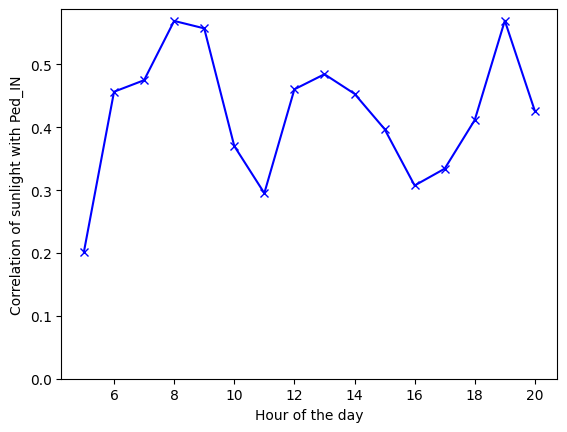

In [85]:
morn_corr={}
for k in range(1,24):
  df_hour=df_weekend[df_weekend["hour"]==k]#made a dataframe looking only at kth hour of the day
  morn_corr[k]=df_hour['Ped_IN'].corr(df_hour['Solar Radiation (W/m^2)'])
  print(k, '\t', df_hour['Ped_IN'].corr(df_hour['Solar Radiation (W/m^2)']))
plt.figure()

plt.plot(list(morn_corr.keys()), list(morn_corr.values()), 'bx-')

plt.xlabel("Hour of the day")

plt.ylabel("Correlation of sunlight with Ped_IN")
plt.ylim(bottom=0)
plt.show()

8-9AM and 7pm are the times Ped count is most sensitive to sunshine.  

1 	 0.2961948990895631
2 	 0.26268059005474004
3 	 0.07589827996524869
4 	 0.10634952848977607
5 	 0.24604208170807793
6 	 0.4494125048676805
7 	 0.5474038752698037
8 	 0.5872011124663021
9 	 0.5620391833857517
10 	 0.3428110133778641
11 	 0.19841409359850534
12 	 0.2327660316160836
13 	 0.30831418769801533
14 	 0.2460347123166752
15 	 0.2336130649822103
16 	 0.20820215445132992
17 	 0.35936612543496266
18 	 0.5891625285353105
19 	 0.7320990120248436
20 	 0.6748255317371703
21 	 0.597545524065222
22 	 0.43762275972013964
23 	 0.36181815432625697


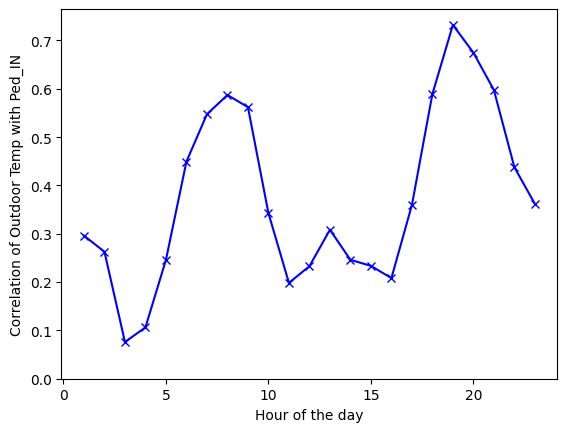

In [86]:
morn_corr={}
for k in range(1,24):
  df_hour=df_weekend[df_weekend["hour"]==k]#made a dataframe
  morn_corr[k]=df_hour['Ped_IN'].corr(df_hour['Outdoor Temperature (°F)'])
  print(k, '\t', df_hour['Ped_IN'].corr(df_hour['Outdoor Temperature (°F)']))
plt.figure()

plt.plot(list(morn_corr.keys()), list(morn_corr.values()), 'bx-')

plt.xlabel("Hour of the day")

plt.ylabel("Correlation of Outdoor Temp with Ped_IN")
plt.ylim(bottom=0)
plt.show()

Again 8AM and 7PM.  This might just be capturing seasonality, as these are the hours where sunlight is most variable by time year.  

### **Conclusions about effect of weather on Pedestrian Traffic**
* 8-9AM and 7pm seem to be the time when people are making weather-informed decisions about whether to take the Community Path to/from work.  

#### **Weekend correlations with other variables, all hours of day**

In [87]:
weekday = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday']
weekend = ['Saturday', 'Sunday']
df_weekday=df_master[df_master['week_day'].isin(weekday)]
df_weekend=df_master[df_master['week_day'].isin(weekend)]
df_master['IsWeekend']=df_master['week_day'].apply(lambda x: 1 if x in weekend else 0)
df_master['IsWeekend'].value_counts()

IsWeekend
0    24544
1     9755
Name: count, dtype: int64

<Axes: >

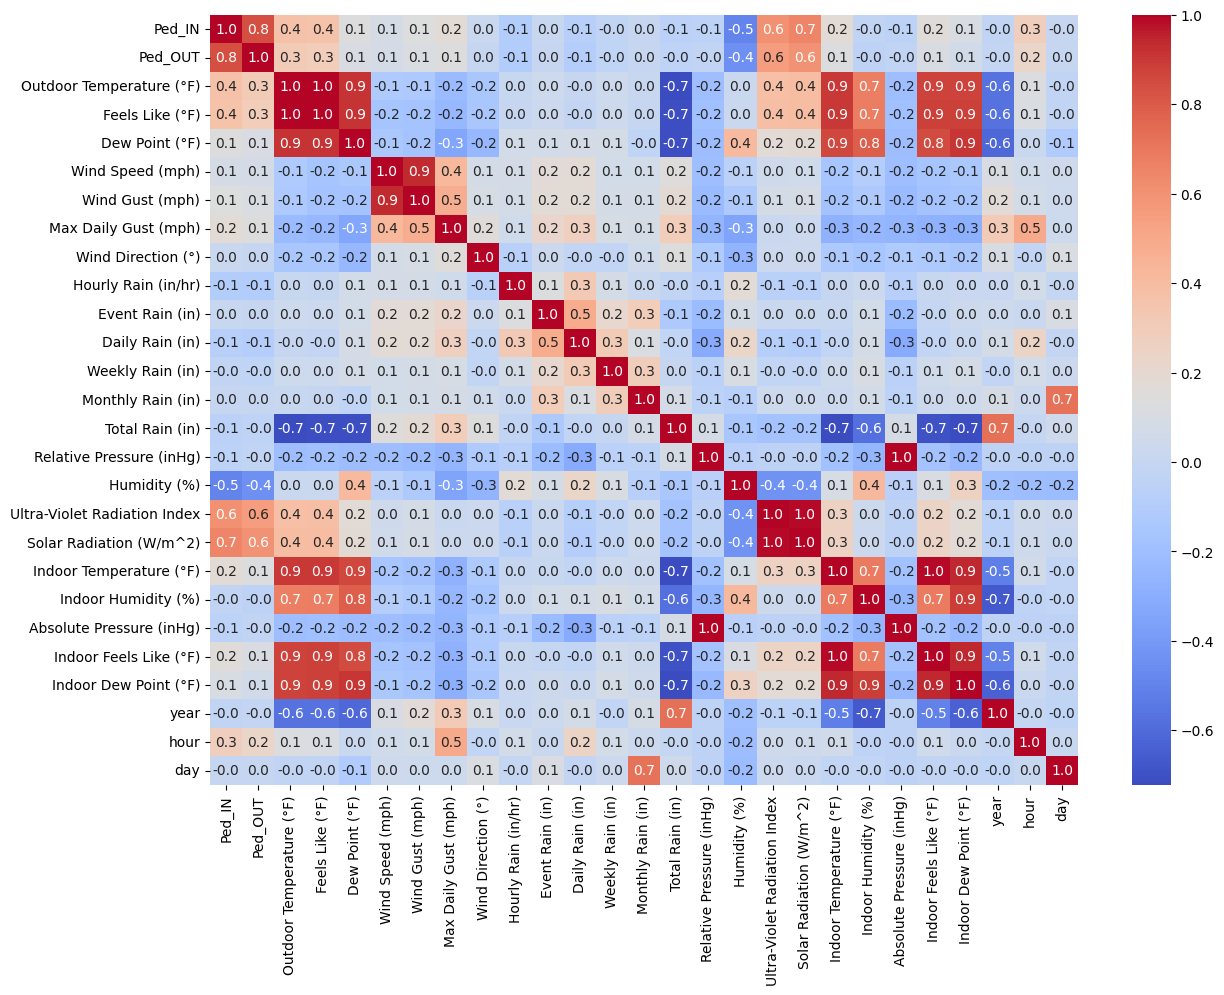

In [88]:
corr=df_weekend[num_cols].corr()
# Plot the heatmap
plt.figure(figsize = (14, 10))
sns.heatmap(corr, annot = True, cmap = 'coolwarm',
        fmt = ".1f",
        xticklabels = corr.columns,
        yticklabels = corr.columns)

## **Machine Learning: Regression - Predicting Ped_IN from weather variables**

In [89]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34299 entries, 0 to 34332
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Dt                            34299 non-null  datetime64[ns]
 1   Ped_IN                        34299 non-null  int64         
 2   Ped_OUT                       34299 non-null  int64         
 3   Outdoor Temperature (°F)      34299 non-null  float64       
 4   Feels Like (°F)               34299 non-null  float64       
 5   Dew Point (°F)                34299 non-null  float64       
 6   Wind Speed (mph)              34299 non-null  float64       
 7   Wind Gust (mph)               34299 non-null  float64       
 8   Max Daily Gust (mph)          34299 non-null  float64       
 9   Wind Direction (°)            34299 non-null  int64         
 10  Hourly Rain (in/hr)           34299 non-null  float64       
 11  Event Rain (in)               342

In [90]:
df_reg=df_master[df_master['hour']==19]#only look at 7pm values to control for commuting patterns
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1423 entries, 73 to 34250
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Dt                            1423 non-null   datetime64[ns]
 1   Ped_IN                        1423 non-null   int64         
 2   Ped_OUT                       1423 non-null   int64         
 3   Outdoor Temperature (°F)      1423 non-null   float64       
 4   Feels Like (°F)               1423 non-null   float64       
 5   Dew Point (°F)                1423 non-null   float64       
 6   Wind Speed (mph)              1423 non-null   float64       
 7   Wind Gust (mph)               1423 non-null   float64       
 8   Max Daily Gust (mph)          1423 non-null   float64       
 9   Wind Direction (°)            1423 non-null   int64         
 10  Hourly Rain (in/hr)           1423 non-null   float64       
 11  Event Rain (in)               142

In [91]:
#indoor "weather", as only variable contingent on outdoor weather
indoor_cols = [col for col in df_weekday.columns.to_list() if "Indoor" in col]
indoor_cols

['Indoor Temperature (°F)',
 'Indoor Humidity (%)',
 'Indoor Feels Like (°F)',
 'Indoor Dew Point (°F)']

Dropping the outcome variable (Ped_IN) from the feature set along with indoor weather, hour, day, month, and year. We know that commuting patterns will create strong correlations with hour and day of the week, day of the month should have no predictive power, while month and year should only have effects that are only due to weather differences. We also drop "PF", since all special event outliers have been removed.

#### **Heat plot correlation of regression variables**

<Axes: >

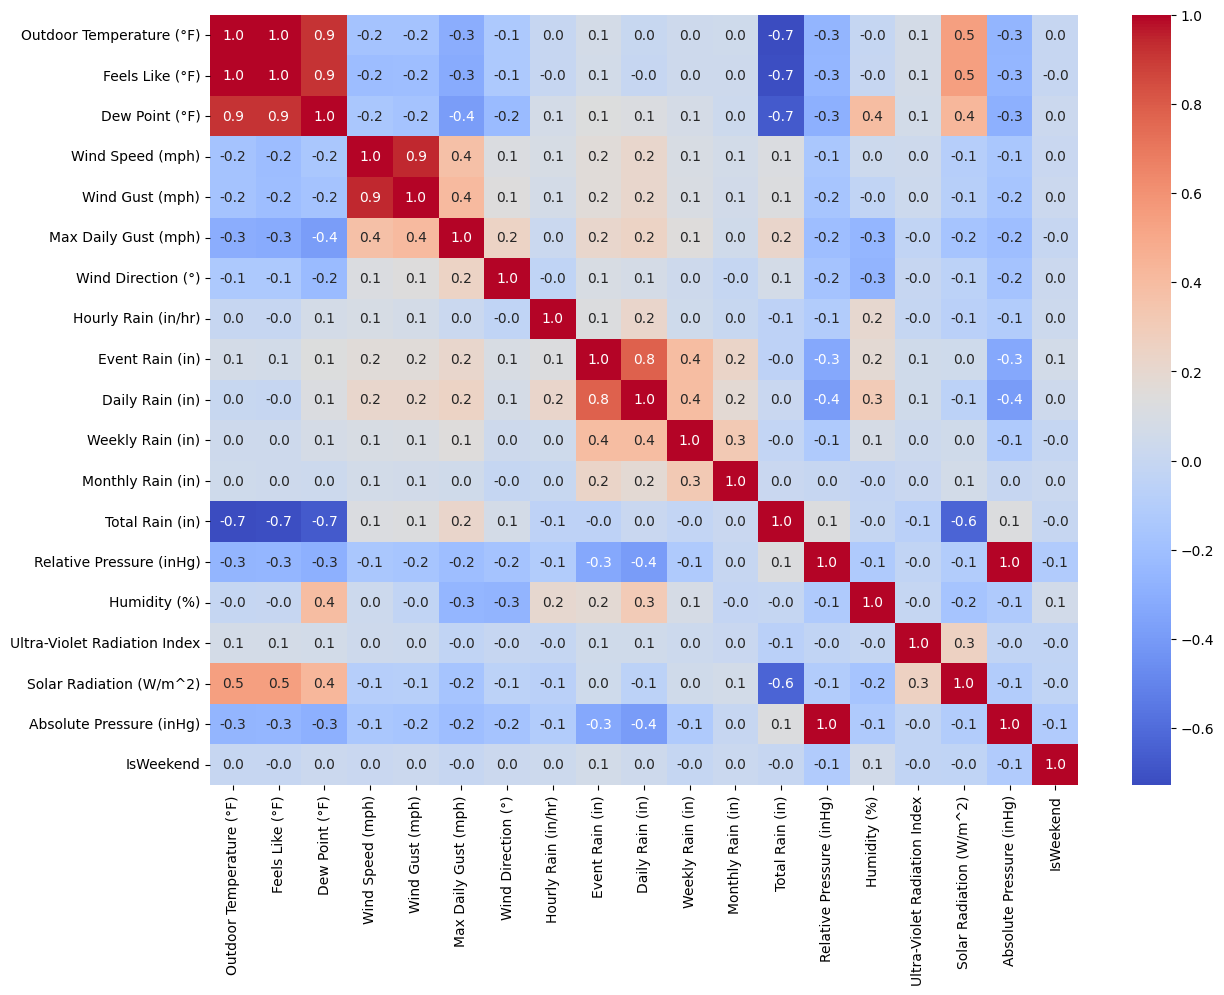

In [92]:
train_features = df_reg.drop(['Ped_IN', 'month', 'week_day', 'Dt', 'Ped_OUT', 'hour', 'day', 'year', 'month','PF'] + indoor_cols, axis = 1)
#train_features_weekend = df_weekend.drop(['Ped_IN', 'month', 'week_day', 'Dt', 'Ped_OUT'] + indoor_cols, axis = 1)
train_target = df_reg['Ped_IN']
#train_target_weeknd = df_weekend['Ped_IN']
num_cols=train_features.select_dtypes(include=['number']).columns.tolist()
corr=train_features[num_cols].corr()
# Plot the heatmap
plt.figure(figsize = (14, 10))
sns.heatmap(corr, annot = True, cmap = 'coolwarm',
        fmt = ".1f",
        xticklabels = corr.columns,
        yticklabels = corr.columns)

In [93]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1423 entries, 73 to 34250
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Outdoor Temperature (°F)      1423 non-null   float64
 1   Feels Like (°F)               1423 non-null   float64
 2   Dew Point (°F)                1423 non-null   float64
 3   Wind Speed (mph)              1423 non-null   float64
 4   Wind Gust (mph)               1423 non-null   float64
 5   Max Daily Gust (mph)          1423 non-null   float64
 6   Wind Direction (°)            1423 non-null   int64  
 7   Hourly Rain (in/hr)           1423 non-null   float64
 8   Event Rain (in)               1423 non-null   float64
 9   Daily Rain (in)               1423 non-null   float64
 10  Weekly Rain (in)              1423 non-null   float64
 11  Monthly Rain (in)             1423 non-null   float64
 12  Total Rain (in)               1423 non-null   float64
 13  Relati

In [94]:
# Creating an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Applying fit_transform on the training features data
train_features_scaled = scaler.fit_transform(train_features)


# The above scaler returns the data in array format, below we are converting it back to pandas DataFrame
train_features_scaled = pd.DataFrame(train_features_scaled, index = train_features.index, columns = train_features.columns)


train_features_scaled.head()

Outdoor Temperature (°F)  Feels Like (°F)  Dew Point (°F)  \
73                   0.489189         0.487882        0.257104   
74                   0.481081         0.481560        0.250338   
75                   0.467568         0.452055        0.247632   
76                   0.459459         0.451001        0.250338   
169                  0.586486         0.563751        0.416779   

     Wind Speed (mph)  Wind Gust (mph)  Max Daily Gust (mph)  \
73           0.116883         0.353846              0.571809   
74           0.259740         0.353846              0.571809   
75           0.318182         0.353846              0.571809   
76           0.259740         0.297436              0.571809   
169          0.000000         0.000000              0.239362   

     Wind Direction (°)  Hourly Rain (in/hr)  Event Rain (in)  \
73             0.910864                  0.0              0.0   
74             0.986072                  0.0              0.0   
75             0.963788                  0.0              0.0   
76             0.016713                  0.0              0.0   
169            0.922006                  0.0              0.0   

     Daily Rain (in)  Weekly Rain (in)  Monthly Rain (in)  Total Rain (in)  \
73               0.0               0.0           0.103324              0.0   
74               0.0               0.0           0.103324              0.0   
75               0.0               0.0           0.103324              0.0   
76               0.0               0.0           0.103324              0.0   
169              0.0               0.0           0.103324              0.0   

     Relative Pressure (inHg)  Humidity (%)  Ultra-Violet Radiation Index  \
73                   0.560811      0.106667                           0.0   
74                   0.567568      0.106667                           0.0   
75                   0.574324      0.120000                           0.0   
76                   0.581081      0.133333                           0.0   
169                  0.783784      0.213333                           0.0   

     Solar Radiation (W/m^2)  Absolute Pressure (inHg)  IsWeekend  
73                  0.370787                  0.560811        0.0  
74                  0.265341                  0.567568        0.0  
75                  0.165082                  0.574324        0.0  
76                  0.082109                  0.581081        0.0  
169                 0.420052                  0.783784        0.0

In [95]:
# Adding the intercept term
train_features_scaled = sm.add_constant(train_features_scaled)

# Calling the OLS algorithm on the train features and the target variable
ols_model_0 = sm.OLS(train_target, train_features_scaled)

# Fitting the Model
ols_res_0 = ols_model_0.fit()

print(ols_res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     124.8
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          7.90e-285
Time:                        15:39:45   Log-Likelihood:                -5263.4
No. Observations:                1423   AIC:                         1.057e+04
Df Residuals:                    1403   BIC:                         1.067e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### **Feature Selection**

#### **Removing Multicollinearity**



In [96]:
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled.values, i) for i in range(train_features_scaled.shape[1])],
    index = train_features_scaled.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                            394.416387
Outdoor Temperature (°F)         361.602377
Feels Like (°F)                  165.985502
Dew Point (°F)                   287.701802
Wind Speed (mph)                   9.874380
Wind Gust (mph)                    9.249165
Max Daily Gust (mph)               1.688007
Wind Direction (°)                 1.236079
Hourly Rain (in/hr)                1.112932
Event Rain (in)                    2.782979
Daily Rain (in)                    3.313145
Weekly Rain (in)                   1.383200
Monthly Rain (in)                  1.202598
Total Rain (in)                    2.803330
Relative Pressure (inHg)        7239.589156
Humidity (%)                      48.504987
Ultra-Violet Radiation Index       1.106022
Solar Radiation (W/m^2)            2.049594
Absolute Pressure (inHg)        7242.376903
IsWeekend                          1.032174
dtype: float64



Removing *Absolute Pressure* for its high VIF score and for its singularly high p-value of 0.364.  

In [97]:
train_features_scaled_2 = train_features_scaled.drop("Absolute Pressure (inHg)", axis = 1)
dropped_features = ["Absolute Pressure (inHg)"]

vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_2.values, i) for i in range(train_features_scaled_2.shape[1])],
    index = train_features_scaled_2.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                           394.289687
Outdoor Temperature (°F)        360.890468
Feels Like (°F)                 165.625242
Dew Point (°F)                  287.675323
Wind Speed (mph)                  9.867426
Wind Gust (mph)                   9.242252
Max Daily Gust (mph)              1.687982
Wind Direction (°)                1.235785
Hourly Rain (in/hr)               1.111666
Event Rain (in)                   2.781679
Daily Rain (in)                   3.310682
Weekly Rain (in)                  1.382946
Monthly Rain (in)                 1.202356
Total Rain (in)                   2.801566
Relative Pressure (inHg)          1.529233
Humidity (%)                     48.504469
Ultra-Violet Radiation Index      1.105890
Solar Radiation (W/m^2)           2.049294
IsWeekend                         1.031441
dtype: float64



In [98]:
#rebuilding model
ols_model_2 = sm.OLS(train_target, train_features_scaled_2)
ols_res_2 = ols_model_2.fit()

In [99]:
print(ols_res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     131.7
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          1.02e-285
Time:                        15:39:45   Log-Likelihood:                -5263.9
No. Observations:                1423   AIC:                         1.057e+04
Df Residuals:                    1404   BIC:                         1.067e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

We note that the R^2 of the model is unaffected. We drop "Relative Pressure (inHg)" for its p-value of 0.935.

In [100]:
train_features_scaled_3 = train_features_scaled_2.drop("Relative Pressure (inHg)", axis = 1)
dropped_features.append("Relative Pressure (inHg)")
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_3.values, i) for i in range(train_features_scaled_3.shape[1])],
    index = train_features_scaled_3.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                           331.813989
Outdoor Temperature (°F)        360.407462
Feels Like (°F)                 165.624454
Dew Point (°F)                  287.655932
Wind Speed (mph)                  9.855442
Wind Gust (mph)                   9.210792
Max Daily Gust (mph)              1.598116
Wind Direction (°)                1.179053
Hourly Rain (in/hr)               1.110328
Event Rain (in)                   2.781675
Daily Rain (in)                   3.193585
Weekly Rain (in)                  1.380802
Monthly Rain (in)                 1.192216
Total Rain (in)                   2.739268
Humidity (%)                     48.434253
Ultra-Violet Radiation Index      1.105437
Solar Radiation (W/m^2)           2.037183
IsWeekend                         1.019349
dtype: float64



In [101]:
#rebuilding model
ols_model_3 = sm.OLS(train_target, train_features_scaled_3)
ols_res_3 = ols_model_3.fit()
print(ols_res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     139.6
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          8.56e-287
Time:                        15:39:46   Log-Likelihood:                -5263.9
No. Observations:                1423   AIC:                         1.056e+04
Df Residuals:                    1405   BIC:                         1.066e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

R^2 of model is unaffected. Let's remove Monthly Rain (in), which we expected to be unrelated to Ped_IN.

In [102]:
train_features_scaled_4 = train_features_scaled_3.drop("Monthly Rain (in)", axis = 1)
dropped_features.append( "Monthly Rain (in)")
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_4.values, i) for i in range(train_features_scaled_4.shape[1])],
    index = train_features_scaled_4.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                           330.403945
Outdoor Temperature (°F)        351.031714
Feels Like (°F)                 165.151290
Dew Point (°F)                  281.345050
Wind Speed (mph)                  9.852565
Wind Gust (mph)                   9.208736
Max Daily Gust (mph)              1.597502
Wind Direction (°)                1.177600
Hourly Rain (in/hr)               1.110003
Event Rain (in)                   2.750855
Daily Rain (in)                   3.188672
Weekly Rain (in)                  1.266493
Total Rain (in)                   2.722179
Humidity (%)                     47.543249
Ultra-Violet Radiation Index      1.105059
Solar Radiation (W/m^2)           2.032083
IsWeekend                         1.019218
dtype: float64



In [103]:
#rebuilding model
ols_model_4 = sm.OLS(train_target, train_features_scaled_4)
ols_res_4 = ols_model_4.fit()
print(ols_res_4.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     148.1
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          1.73e-287
Time:                        15:39:46   Log-Likelihood:                -5264.8
No. Observations:                1423   AIC:                         1.056e+04
Df Residuals:                    1406   BIC:                         1.065e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

We drop Outdoor Temperature (°F) for its high collinearity VIF score.

In [104]:
train_features_scaled_5 = train_features_scaled_4.drop("Outdoor Temperature (°F)", axis = 1)
dropped_features.append("Outdoor Temperature (°F)")
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_5.values, i) for i in range(train_features_scaled_5.shape[1])],
    index = train_features_scaled_5.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                           259.610488
Feels Like (°F)                 110.251350
Dew Point (°F)                  130.946641
Wind Speed (mph)                  9.462548
Wind Gust (mph)                   9.132764
Max Daily Gust (mph)              1.589771
Wind Direction (°)                1.167040
Hourly Rain (in/hr)               1.102431
Event Rain (in)                   2.745642
Daily Rain (in)                   3.161139
Weekly Rain (in)                  1.231607
Total Rain (in)                   2.716885
Humidity (%)                     21.880005
Ultra-Violet Radiation Index      1.101649
Solar Radiation (W/m^2)           2.029480
IsWeekend                         1.014661
dtype: float64



In [105]:
#rebuilding model
ols_model_5 = sm.OLS(train_target, train_features_scaled_5)
ols_res_5 = ols_model_5.fit()
print(ols_res_5.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     152.7
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          4.47e-282
Time:                        15:39:46   Log-Likelihood:                -5280.1
No. Observations:                1423   AIC:                         1.059e+04
Df Residuals:                    1407   BIC:                         1.068e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Dropping dewpoint for high VIF score.  We expect it to clean up the VIF scores of "feels like" and "humidity (%)".

In [106]:
train_features_scaled_6 = train_features_scaled_5.drop("Dew Point (°F)", axis = 1)
dropped_features.append("Dew Point (°F)")
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_6.values, i) for i in range(train_features_scaled_6.shape[1])],
    index = train_features_scaled_6.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                           86.713040
Feels Like (°F)                  2.356147
Wind Speed (mph)                 8.899385
Wind Gust (mph)                  9.026986
Max Daily Gust (mph)             1.588219
Wind Direction (°)               1.164474
Hourly Rain (in/hr)              1.097361
Event Rain (in)                  2.744718
Daily Rain (in)                  3.145662
Weekly Rain (in)                 1.228582
Total Rain (in)                  2.585381
Humidity (%)                     1.545294
Ultra-Violet Radiation Index     1.101624
Solar Radiation (W/m^2)          2.001476
IsWeekend                        1.014592
dtype: float64



In [107]:
#rebuilding model
ols_model_6 = sm.OLS(train_target,train_features_scaled_6)
ols_res_6 = ols_model_6.fit()
print(ols_res_6.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     143.5
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          6.80e-259
Time:                        15:39:46   Log-Likelihood:                -5336.9
No. Observations:                1423   AIC:                         1.070e+04
Df Residuals:                    1408   BIC:                         1.078e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [108]:
train_features_scaled_7 = train_features_scaled_6.drop("Wind Speed (mph)", axis = 1)
dropped_features.append("Wind Speed (mph)")
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_7.values, i) for i in range(train_features_scaled_7.shape[1])],
    index = train_features_scaled_7.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                           86.648240
Feels Like (°F)                  2.348244
Wind Gust (mph)                  1.244606
Max Daily Gust (mph)             1.588041
Wind Direction (°)               1.164340
Hourly Rain (in/hr)              1.096685
Event Rain (in)                  2.744716
Daily Rain (in)                  3.145554
Weekly Rain (in)                 1.228512
Total Rain (in)                  2.583487
Humidity (%)                     1.512359
Ultra-Violet Radiation Index     1.100456
Solar Radiation (W/m^2)          2.001475
IsWeekend                        1.012971
dtype: float64



In [109]:
#rebuilding model
ols_model_7 = sm.OLS(train_target,train_features_scaled_7)
ols_res_7 = ols_model_7.fit()
print(ols_res_7.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     154.6
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          5.42e-260
Time:                        15:39:46   Log-Likelihood:                -5336.9
No. Observations:                1423   AIC:                         1.070e+04
Df Residuals:                    1409   BIC:                         1.078e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [110]:
train_features_scaled_8 = train_features_scaled_7.drop("Wind Gust (mph)", axis = 1)
dropped_features.append("Wind Gust (mph)")
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_8.values, i) for i in range(train_features_scaled_8.shape[1])],
    index = train_features_scaled_8.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                           86.542729
Feels Like (°F)                  2.323153
Max Daily Gust (mph)             1.436071
Wind Direction (°)               1.162071
Hourly Rain (in/hr)              1.094743
Event Rain (in)                  2.744228
Daily Rain (in)                  3.129418
Weekly Rain (in)                 1.228396
Total Rain (in)                  2.582803
Humidity (%)                     1.510563
Ultra-Violet Radiation Index     1.099190
Solar Radiation (W/m^2)          1.998086
IsWeekend                        1.012438
dtype: float64



In [111]:
#rebuilding model
ols_model_8 = sm.OLS(train_target,train_features_scaled_8)
ols_res_8 = ols_model_8.fit()
print(ols_res_8.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     167.6
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          4.54e-261
Time:                        15:39:46   Log-Likelihood:                -5337.0
No. Observations:                1423   AIC:                         1.070e+04
Df Residuals:                    1410   BIC:                         1.077e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [112]:
train_features_scaled_9 = train_features_scaled_8.drop("Total Rain (in)", axis = 1)
dropped_features.append("Total Rain (in)")
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_9.values, i) for i in range(train_features_scaled_9.shape[1])],
    index = train_features_scaled_9.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                           40.571992
Feels Like (°F)                  1.585960
Max Daily Gust (mph)             1.433324
Wind Direction (°)               1.155866
Hourly Rain (in/hr)              1.081995
Event Rain (in)                  2.743700
Daily Rain (in)                  3.128158
Weekly Rain (in)                 1.227747
Humidity (%)                     1.489424
Ultra-Violet Radiation Index     1.088227
Solar Radiation (W/m^2)          1.619683
IsWeekend                        1.012350
dtype: float64



In [113]:
#rebuilding model
ols_model_9 = sm.OLS(train_target,train_features_scaled_9)
ols_res_9 = ols_model_9.fit()
print(ols_res_9.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     182.2
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          1.88e-261
Time:                        15:39:46   Log-Likelihood:                -5338.8
No. Observations:                1423   AIC:                         1.070e+04
Df Residuals:                    1411   BIC:                         1.076e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

We are suspicious of the Ultra-Violet Radiation Index variable, given that we've trimmed down the data to only 7pm, where this index is likely to vary very little.

In [114]:
df_reg['Ultra-Violet Radiation Index'].value_counts()

Ultra-Violet Radiation Index
0    1420
1       3
Name: count, dtype: int64

Confirmed, this variable should be removed, as the sun's UV is nearly non-existent at 7pm.  Let's check solar radiation.

In [115]:
df_reg['Solar Radiation (W/m^2)'].value_counts()

Solar Radiation (W/m^2)
0.0     908
5.1      14
0.8      13
0.4      12
3.8      11
       ... 
72.8      1
71.1      1
65.9      1
33.8      1
45.5      1
Name: count, Length: 158, dtype: int64

In [116]:
train_features_scaled_10 = train_features_scaled_9.drop("Ultra-Violet Radiation Index", axis = 1)
dropped_features.append("Ultra-Violet Radiation Index")
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_10.values, i) for i in range(train_features_scaled_10.shape[1])],
    index = train_features_scaled_10.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                      40.554112
Feels Like (°F)             1.573344
Max Daily Gust (mph)        1.432948
Wind Direction (°)          1.155804
Hourly Rain (in/hr)         1.081952
Event Rain (in)             2.743067
Daily Rain (in)             3.118776
Weekly Rain (in)            1.227706
Humidity (%)                1.488778
Solar Radiation (W/m^2)     1.504812
IsWeekend                   1.011800
dtype: float64



In [117]:
#rebuilding model
ols_model_10 = sm.OLS(train_target,train_features_scaled_10)
ols_res_10 = ols_model_10.fit()
print(ols_res_10.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     198.9
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          3.48e-261
Time:                        15:39:47   Log-Likelihood:                -5342.1
No. Observations:                1423   AIC:                         1.071e+04
Df Residuals:                    1412   BIC:                         1.076e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

It seems suspicious that Event Rain increases turnout.  As shown above, Event Rain is strongly correlated with other cumulative rain stats, such as Daily and Weekly Rain.  It may also have the added bonus of reducing the VIF factors for those other cumulative rain variables.

In [118]:
train_features_scaled_11 = train_features_scaled_10.drop("Event Rain (in)", axis = 1)
dropped_features.append("Event Rain (in)")
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_11.values, i) for i in range(train_features_scaled_11.shape[1])],
    index = train_features_scaled_11.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                      40.542243
Feels Like (°F)             1.568099
Max Daily Gust (mph)        1.431508
Wind Direction (°)          1.153783
Hourly Rain (in/hr)         1.078540
Daily Rain (in)             1.534549
Weekly Rain (in)            1.206042
Humidity (%)                1.485719
Solar Radiation (W/m^2)     1.495684
IsWeekend                   1.007191
dtype: float64



Confirmed: VIF numbers all below 2. What about R^2?

In [119]:
#rebuilding model
ols_model_11 = sm.OLS(train_target,train_features_scaled_11)
ols_res_11 = ols_model_11.fit()
print(ols_res_11.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     216.8
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          8.41e-259
Time:                        15:39:47   Log-Likelihood:                -5350.4
No. Observations:                1423   AIC:                         1.072e+04
Df Residuals:                    1413   BIC:                         1.077e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

We note that Daily Rain's p-value just shot up to 0.918.  We remove this as well.  We also are suspicious of **Wind Direction (°)**, as an overfit.  At the same temperature, humidity, sunshine, and wind speed, do we really think a southerly wind vs. a westerly wind will affect people's choices in using the path?

In [120]:
train_features_scaled_12 = train_features_scaled_11.drop(["Daily Rain (in)", "Wind Direction (°)"], axis = 1)
dropped_features.append(["Daily Rain (in)", "Wind Direction (°)"])
vif_series = pd.Series(
    [variance_inflation_factor(train_features_scaled_12.values, i) for i in range(train_features_scaled_12.shape[1])],
    index = train_features_scaled_12.columns,
    dtype = float)

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

const                      30.440559
Feels Like (°F)             1.548322
Max Daily Gust (mph)        1.271112
Hourly Rain (in/hr)         1.052054
Weekly Rain (in)            1.056793
Humidity (%)                1.209827
Solar Radiation (W/m^2)     1.494004
IsWeekend                   1.005210
dtype: float64



In [121]:
#rebuilding model
ols_model_12 = sm.OLS(train_target,train_features_scaled_12)
ols_res_12 = ols_model_12.fit()
print(ols_res_12.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     272.6
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          4.42e-257
Time:                        15:39:47   Log-Likelihood:                -5360.1
No. Observations:                1423   AIC:                         1.074e+04
Df Residuals:                    1415   BIC:                         1.078e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

We are satisfied with our final model for the general qualitative impact of each variable: rain, wind, and humidity decrease turnout while sun and warmth increase pedestrian turnout.  We suspect the positive impact of "Feels like" has more to do with the deterring effect of cold weather wind chill than of hot weather heat index.

####**Checking the model**

Residuals should be near 0 with normally distributed error terms.

In [122]:
# Residuals
residual = ols_res_12.resid
residual.mean()

-1.1704231712028635e-14

<Axes: ylabel='Count'>

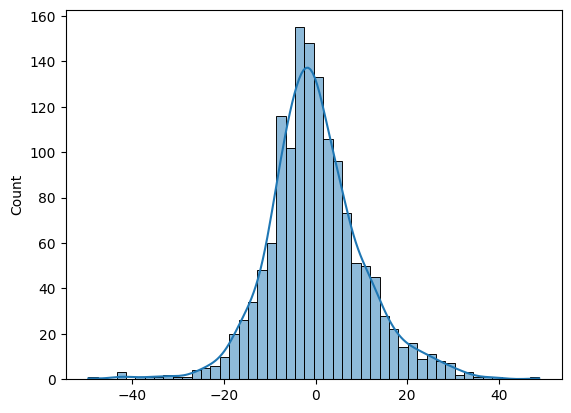

In [123]:
# Plot histogram of residuals
sns.histplot(residual, kde = True)

####**Linearity of variables**

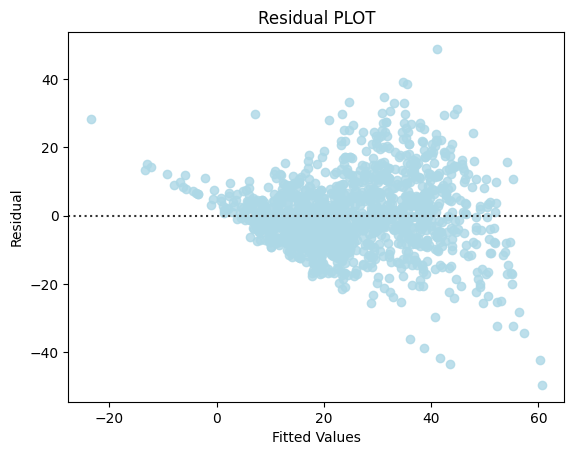

In [124]:
# Predicted values
fitted = ols_res_12.fittedvalues

sns.residplot(x = fitted, y = residual, color = "lightblue")

plt.xlabel("Fitted Values")

plt.ylabel("Residual")

plt.title("Residual PLOT")

plt.show()

**Observations:**

- We can see that there is some pattern in fitted values and residuals, i.e., the residuals are not randomly distributed.
- Let's try to fix this. We can apply the log transformation on the target variable and try to build a new model.

In [125]:
# sqrt transformation on the target variable
train_target_sqrt = np.sqrt(train_target)#adding small constant to offset log(0) = -infinity

In [126]:
# Fitting new model with the transformed target variable
ols_model_13 = sm.OLS(train_target_sqrt, train_features_scaled_12)
ols_res_13 = ols_model_13.fit()
print(ols_res_13.summary())

                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     284.7
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          8.57e-265
Time:                        15:39:48   Log-Likelihood:                -2119.7
No. Observations:                1423   AIC:                             4255.
Df Residuals:                    1415   BIC:                             4298.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

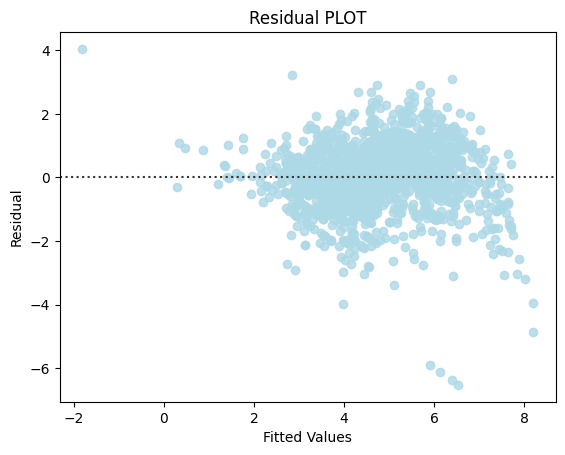

In [127]:
# Predicted values
fitted = ols_res_13.fittedvalues

residual1 = ols_res_13.resid

sns.residplot(x = fitted, y = residual1, color = "lightblue")

plt.xlabel("Fitted Values")

plt.ylabel("Residual")

plt.title("Residual PLOT")

plt.show()

**Observations:**

- We have eliminated the pattern in our residuals vs. fitted values plot so linearity is now satisfied.
- We note that our R^2 increased to 0.59 from the tranformation.

In [128]:
print(ols_res_13.summary())


                            OLS Regression Results                            
Dep. Variable:                 Ped_IN   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     284.7
Date:                Mon, 08 Jul 2024   Prob (F-statistic):          8.57e-265
Time:                        15:39:48   Log-Likelihood:                -2119.7
No. Observations:                1423   AIC:                             4255.
Df Residuals:                    1415   BIC:                             4298.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

##**No heteroscedasticity**

In [129]:
from statsmodels.stats.diagnostic import het_white

from statsmodels.compat import lzip

import statsmodels.stats.api as sms

In [130]:
import statsmodels.stats.api as sms

from statsmodels.compat import lzip

name = ["F statistic", "p-value"]

test = sms.het_goldfeldquandt(train_target_sqrt, train_features_scaled_12)

lzip(name, test)

[('F statistic', 0.9870510161107424), ('p-value', 0.5685831049218875)]

p-vaue is far greater than 0.05 so the residuals are homoscedastic.

The final equation of the model is as follows:

**$\sqrt($ Ped_IN $)$ $= 3.5414 + 4.8861 *$ Feels Like$ -0.5799 *$ Max Daily Gust (mph) $  -6.7644*$ Hourly Rain (in/hr) $ -0.4490* $ Weekly Rain (in) $ - 1.5234*$ Humidity (%) $ +  0.9870*$ Solar Radiation (W/m^2) $ + 0.225*$ IsWeekend**

*continue updating*

const                       3.5414      0.157     22.497      0.000       3.233       3.850
Feels Like (°F)             4.9437      0.190     26.008      0.000       4.571       5.317
Max Daily Gust (mph)       -0.7100      0.192     -3.690      0.000      -1.087      -0.333
Hourly Rain (in/hr)        -6.7980      0.798     -8.524      0.000      -8.362      -5.233
Weekly Rain (in)           -0.4880      0.167     -2.918      0.004      -0.816      -0.160
Humidity (%)               -1.3653      0.131    -10.453      0.000      -1.621      -1.109
Solar Radiation (W/m^2)     1.0246      0.227      4.515      0.000       0.579       1.470
IsWeekend                  -1.0862

In [131]:
'''without_const = train_features_scaled.iloc[:, 1:]
#print(without_const)
test_features = pd.get_dummies(test_df, drop_first = True)

test_features = test_features[list(without_const)]

# Applying transform on the test data
test_features_scaled = scaler.transform(test_features)

test_features_scaled = pd.DataFrame(test_features_scaled, columns = without_const.columns)

test_features_scaled = sm.add_constant(test_features_scaled)

test_features_scaled = test_features_scaled.drop(dropped_features)
#test_features_scaled.head()'''

'without_const = train_features_scaled.iloc[:, 1:]\n#print(without_const)\ntest_features = pd.get_dummies(test_df, drop_first = True)\n\ntest_features = test_features[list(without_const)]\n\n# Applying transform on the test data\ntest_features_scaled = scaler.transform(test_features)\n\ntest_features_scaled = pd.DataFrame(test_features_scaled, columns = without_const.columns)\n\ntest_features_scaled = sm.add_constant(test_features_scaled)\n\ntest_features_scaled = test_features_scaled.drop(dropped_features)\n#test_features_scaled.head()'

In [132]:
print(ols_res_13.rsquared)

0.584811330567504


In [133]:
print(ols_res_13.mse_resid)

1.1583700298699284


In [134]:
print(np.sqrt(ols_res_13.mse_resid))

1.0762760007869396


###**Cross validation of model**

In [135]:
# Fitting linear model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linearregression = LinearRegression()

cv_Score11 = cross_val_score(linearregression, train_features_scaled_12, train_target_sqrt, cv = 5)

cv_Score12 = cross_val_score(linearregression, train_features_scaled_12, train_target_sqrt, cv = 5,
                             scoring = 'neg_mean_squared_error')


print("RSquared: %0.3f (+/- %0.3f)" % (cv_Score11.mean(), cv_Score11.std()*2))

print("Mean Squared Error: %0.3f (+/- %0.3f)" % (-1*cv_Score12.mean(), cv_Score12.std()*2))

RSquared: 0.164 (+/- 0.433)
Mean Squared Error: 1.461 (+/- 0.860)


Seems we've dramatically overfit the data.  Let's try a Lasso regression.

In [136]:
from sklearn.linear_model import Lasso
# Fit the Lasso regression model
#test_features_scaled = test_features_scaled.drop(dropped_features)
alpha = 0.01  # Regularization strength
lasso = Lasso(alpha=alpha)
Lasso_model=lasso.fit(train_features_scaled_12, train_target_sqrt)
print("Lasso Coefficients:", lasso.coef_)

Lasso Coefficients: [ 0.          4.79776668 -0.5255931  -0.         -0.22871557 -1.41190701
  0.82056897 -1.05533608]


In [137]:
# Extract the coefficients and intercept
coefficients = lasso.coef_
intercept = lasso.intercept_
equation = "y = "
for feature_name, coef in zip(feature_names, coefficients):
    equation += f"{coef:.3f} * {feature_name} + "
equation += f"{intercept:.3f}"

print("Regression Equation:")
print(equation)

NameError: name 'feature_names' is not defined